### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, rcParams

import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
import pydot
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

from bioinfokit.analys import stat
#from sklearn.inspection import partial_dependence, plot_partial_dependence

from progressbar import ProgressBar
pbar = ProgressBar()

global_split_rand = 2571

2023-03-07 21:58:29.534254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 21:58:29.598267: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 21:58:29.889337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-03-07 21:58:29.889390: W tensorflow/compile

Text(0.5, 0, '!!!Ariaaaal')

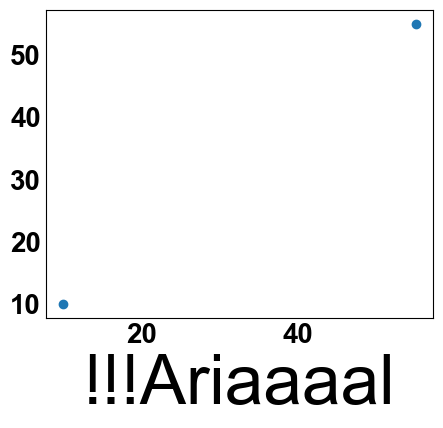

In [2]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [3]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final_simulation_90rem.csv', header=1)
full_df = pd.read_csv('FJH_ML_Final.csv', header=1)

df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']

Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
df['Graphene_Yield'] = 100*df['Graphene_Yield']
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)

In [4]:
# rem. 90 dataset
features_dimred = np.concatenate ((np.array (df['Res_Drop']).reshape(-1, 1),
                                   np.array (df['Volt_Drop']).reshape(-1, 1),
                                   10*np.array (df['I_Max']).reshape(-1, 1),
                                   np.array (df['Norm_I_Max']).reshape(-1, 1), 
                                   np.array (df['Charge_Tot']).reshape(-1, 1), 
                                   #np.array (df['I_Final']).reshape(-1, 1), 
                                   np.array (df['TwoDtoG']).reshape(-1, 1),
                                   np.array (df['DtoG']).reshape(-1, 1),
                                   np.array (df['FWHM_2D']).reshape(-1, 1),
                                   100*np.array (df['Graphene_Yield']).reshape(-1, 1),
                                   100*np.array (df['Yield_Per']).reshape(-1, 1) # convert to %
                                   ), axis=1)

features_dimred_pca = PCA(n_components=6).fit_transform(features_dimred)
tSNE_embedded = TSNE(init='pca', n_iter=10000,learning_rate='auto', n_jobs=-1,
                    perplexity=12, random_state=4, verbose=1).fit_transform(features_dimred)


df['tsne1'] = tSNE_embedded[:, 0]
df['tsne2'] = tSNE_embedded[:, 1]

[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 173 samples in 0.000s...
[t-SNE] Computed neighbors for 173 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 173 / 173
[t-SNE] Mean sigma: 711.348554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.424805
[t-SNE] KL divergence after 3200 iterations: 0.310633


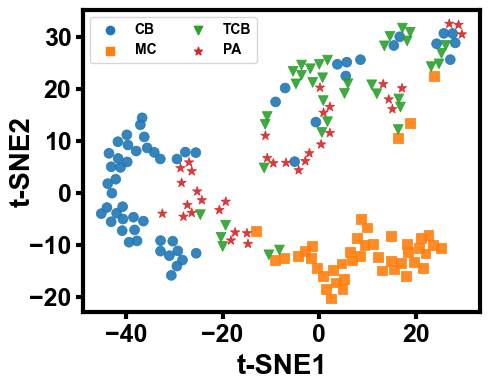

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))
markers = ['o', 's', '*', 'v']
#['*', 's', 'o', 'v']
sns.scatterplot(data=df, x='tsne1', y='tsne2', 
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.9, s=50)

ax.set_xlabel('t-SNE1', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('t-SNE2', fontsize='20', fontname='Arial', fontweight='bold', labelpad=-5)

ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()
#plt.title ('per {}, rand {}'.format(per, rand))
#plt.ylim(-25, 45)
plt.savefig('tsne_all.jpeg', dpi=500)

In [6]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)

In [7]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [8]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)

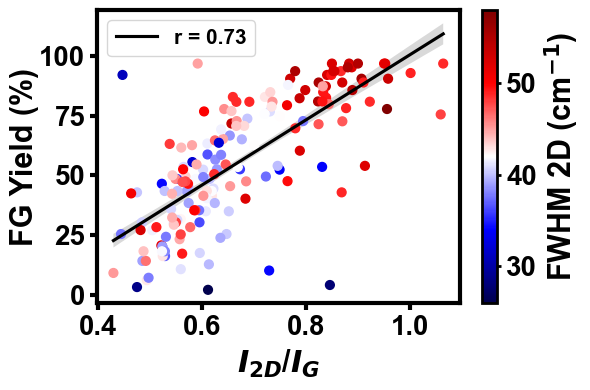

In [9]:
# remove the outliers of crystallinity
df_crystallinity_outlier_rem = df.loc[df['TwoDtoG'] > 0.2].\
                               loc[df['FWHM_2D'] > 20].loc[df['FWHM_2D'] < 80]\
                               .loc[df['DtoG']>0.2]
# Plot pred vs. true values for test set, coloring the charge density
# the same with the next plot, the next one is more accurate for coloring. Small details

fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=0, labelsize='20')

pearr = pearsonr (df_crystallinity_outlier_rem['TwoDtoG'], 
                 df_crystallinity_outlier_rem['Graphene_Yield'])

sns.regplot(data=df_crystallinity_outlier_rem, x='TwoDtoG', y='Graphene_Yield',
            scatter_kws={"color": "red"}, line_kws={"color": "black"}, scatter=False,
            ci=70, order=1, label='r = {}'.format(round (pearr[0], 2)))
plt.legend(loc='upper left', fontsize=15)

p = plt.scatter (df_crystallinity_outlier_rem['TwoDtoG'], 
             df_crystallinity_outlier_rem['Graphene_Yield'], s=40,
                   c=df_crystallinity_outlier_rem['FWHM_2D'], cmap='seismic')
    
cb = fig.colorbar(p, ax=ax)
[i.set_linewidth(2) for i in cb.ax.spines.values()]
cb.ax.tick_params(axis='both', which='major', width=2, length=3,)
cb.ax.tick_params(labelsize=20)
cb.set_label('FWHM 2D (cm$^{-1}$)', fontsize='22', fontname='Arial', fontweight='bold')

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('$I_{2D}$/$I_G$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=0)
#plt.ylim((-10, 120))
#plt.xlim((0.35, 1.2))
# ax.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
# Save
plt.tight_layout()
plt.savefig('TwoDtoG_GY_FWHMcolor.jpeg', dpi=500)

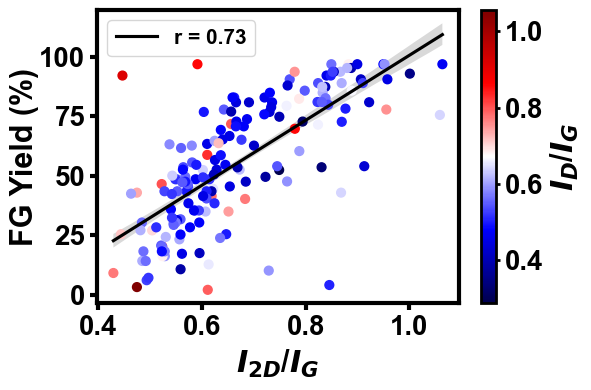

In [10]:
# Plot pred vs. true values for test set, coloring the charge density
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=0, labelsize='20')

pearr = pearsonr (df_crystallinity_outlier_rem['TwoDtoG'], 
                 df_crystallinity_outlier_rem['Graphene_Yield'])

sns.regplot(data=df_crystallinity_outlier_rem, x='TwoDtoG', y='Graphene_Yield',
            scatter_kws={"color": "red"}, line_kws={"color": "black"}, scatter=False,
            ci=70, order=1, label='r = {}'.format(round (pearr[0], 2)))
plt.legend(fontsize=15)
p = plt.scatter (df_crystallinity_outlier_rem['TwoDtoG'], 
                 df_crystallinity_outlier_rem['Graphene_Yield'],
             c=df_crystallinity_outlier_rem['DtoG'], alpha=1, s=40,
             cmap='seismic')
 
cb = fig.colorbar(p, ax=ax)
[i.set_linewidth(2) for i in cb.ax.spines.values()]
cb.ax.tick_params(axis='both', which='major', width=2, length=3)

cb.set_label('$I_{D}$/$I_G$', fontsize='22', fontname='Arial', fontweight='bold')
cb.ax.tick_params(labelsize=20)

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('$I_{2D}$/$I_G$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=0)
#plt.ylim((-10, 120))
#plt.xlim((0.35, 1.2))
# ax.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
# Save
plt.tight_layout()
plt.savefig('TowDtoG_GY_DtoGcolor.jpeg', dpi=500)

In [11]:
df_crystallinity_outlier_rem

,Sample,Material,Atmosphere,Mass,Tube Diam,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,...,DtoG,FWHM_2D,temp1,temp2,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,tsne1,tsne2
0,1,CB,vac,200.0,8,60,60,235,1200,56.0,...,0.546842,52.940275,2371.523708,5116.227986,80.159727,746.820500,112.800000,0.063619,-41.129337,4.892799
2,3,CB,vac,200.0,8,240,60,235,300,161.0,...,0.746614,40.452173,812.743445,1498.919646,35.543043,443.034350,112.800000,0.158840,8.538393,25.595697
3,4,CB,vac,200.0,8,320,80,235,900,43.0,...,0.661025,50.596165,1851.930313,3910.458723,86.790377,513.726500,112.800000,0.099584,-39.814785,11.147732
4,5,CB,air,187.0,8,60,60,145,125,104.6,...,0.500579,40.277124,384.918431,522.445894,19.643746,375.748930,74.438503,0.216167,15.443512,28.324041
5,6,CB,vac,200.0,8,320,80,235,200,110.0,...,0.403399,52.679499,639.545630,1096.996437,56.593311,706.698000,112.800000,0.199556,-43.046577,5.013989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,170,TCB,vac,360.0,8,150,60,175,220,112.0,...,0.394274,41.922440,315.570586,332.150949,30.425001,289.649444,37.916667,0.197223,-3.665282,22.597441
169,171,TCB,vac,321.0,8,210,70,160,430,56.0,...,0.721581,32.193091,362.290104,415.704305,56.169822,676.011215,47.850467,0.096532,-10.766213,14.660872
170,172,TCB,vac,345.0,8,200,100,150,530,32.0,...,0.633724,43.684705,415.204889,506.749328,59.515878,413.002609,57.391304,0.068991,-1.341197,21.228144
171,173,TCB,air,275.0,8,200,100,170,390,33.0,...,0.547242,47.415184,331.555942,363.410495,87.632616,864.124000,37.090909,0.067037,1.709092,13.674364


In [12]:
np.mean (df_crystallinity_outlier_rem['Graphene_Yield'])

55.614495110119044

In [13]:
df_crystallinity_outlier_rem.shape

(168, 35)

In [14]:
df.groupby(['Material']).mean()


/tmp/ipykernel_7485/2354253872.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['Material']).mean()


,Sample,Mass,Tube Diam,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,Cap,Init_R,...,DtoG,FWHM_2D,temp1,temp2,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,tsne1,tsne2
Material,,,,,,,,,,,,,,,,,,,,,
CB,29.000000,186.985965,8.0,201.842105,84.912281,201.666667,385.789474,94.815789,104.070175,1.638596,...,0.609059,49.269528,1053.698316,2671.810342,60.890364,1124.645150,114.100258,0.254620,-24.235828,5.947962
MC,96.681818,274.929545,8.0,194.045455,93.704545,204.568182,207.454545,42.565909,110.727273,0.356818,...,0.573517,39.389795,429.695661,462.466619,72.555175,2035.086376,83.872352,0.105231,9.782197,-10.474107
PA,98.742857,285.545714,8.0,215.828571,93.171429,190.800000,245.342857,63.058571,121.428571,6.368571,...,0.433198,38.422312,499.331604,563.557346,58.887461,1084.348553,84.581804,0.177712,-7.884060,7.203985
TCB,156.000000,319.810811,8.0,167.702703,76.972973,192.918919,306.810811,102.286486,117.405405,7.332703,...,0.505761,46.067929,438.614129,561.603508,44.400898,755.571063,76.061522,0.186118,3.080758,16.569672


mean for Graphene_Yield: 54.05
sd for Graphene_Yield: 27.36
mean for TwoDtoG: 0.66
sd for TwoDtoG: 0.17
mean for FWHM_2D: 43.88
sd for FWHM_2D: 11.55
mean for DtoG: 0.54
sd for DtoG: 0.14


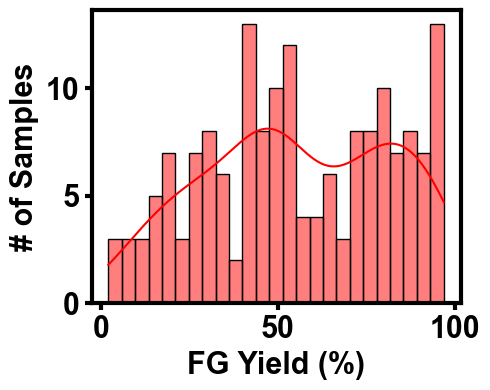

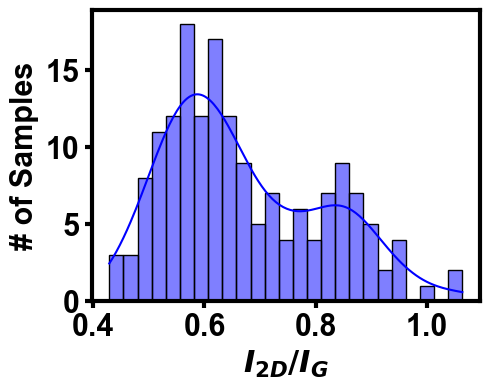

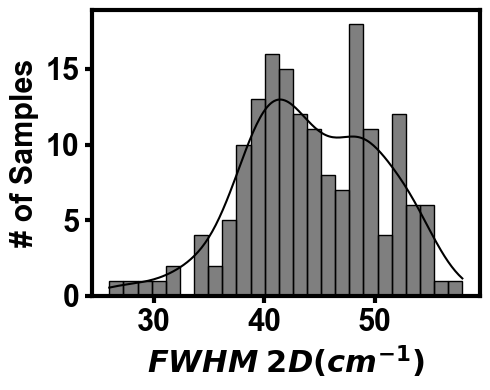

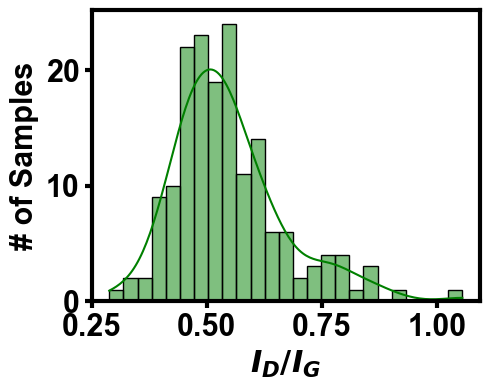

In [15]:
interests = ['Graphene_Yield', 'TwoDtoG', 'FWHM_2D', 'DtoG']
colors = ['red', 'blue', 'black', 'green']
X_labels = ['FG Yield (%)', '$I_{2D}/I_{G}$', '$FWHM$ $2D (cm^{-1})$', '$I_{D}/I_{G}$']
for counter, interest in enumerate(interests):
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.histplot(data=df_crystallinity_outlier_rem[interest], bins=25, color=colors[counter],
                 kde=True,cbar=True)

    plt.xlabel(X_labels[counter], fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
    plt.ylabel('# of Samples', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
    ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')
    [i.set_linewidth(3) for i in ax.spines.values()]
    print ('mean for {}: {}'.format (interest, 
                                     round (np.mean (df[interest]), 2)))
    print ('sd for {}: {}'.format (interest, 
                                   round (np.std (df[interest]), 2)))
    plt.tight_layout()
    plt.savefig('{}_hist.jpeg'.format(interest), dpi=500)

PearsonRResult(statistic=0.43710023577336443, pvalue=1.8246238590957329e-09)


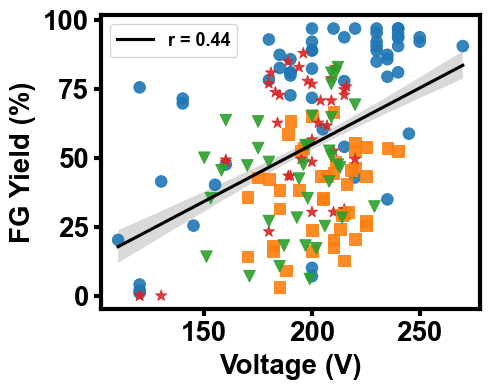

In [16]:
# relation of I_max and GY depend on material group. 
interest = "Voltage"
fig, ax = plt.subplots(figsize=(5, 4))
markers = ['o', 's', '*', 'v']
colors=['blue', 'red', 'green', 'orange']

sns1= sns.regplot(data=df, x=interest, y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=1, scatter=False,)# hue='Material')

sns.scatterplot(data=df, x='Voltage', y='Graphene_Yield', 
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.9, s=70)

plt.xlabel(r'Voltage (V)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]

pearr = pearsonr(df[interest], df['Graphene_Yield'])
print (pearr)
plt.legend([],[], frameon=False)
"""
plt.title("Pearson's r={}, p-value={}".format(round(pearr[0], 2), round(pearr[1], 3)), 
          loc='left', fontname='Arial', fontsize=17, pad=10,
          fontweight='bold', color='darkred')
"""
plt.legend(['r = {}'.format(round(pearr[0], 2))], fontsize=13, frameon=True,)
plt.tight_layout()
plt.savefig('{}_GY.jpeg'.format(interest), dpi=500)

PearsonRResult(statistic=-0.4144595406674684, pvalue=1.4373572893745732e-08)


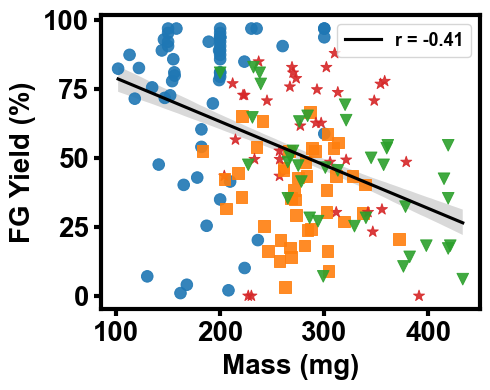

In [17]:
# relation of I_max and GY depend on material group. 
interest = "Mass"
fig, ax = plt.subplots(figsize=(5, 4))
markers = ['o', 's', '*', 'v']
colors=['blue', 'red', 'green', 'orange']

pearr = pearsonr(df[interest], df['Graphene_Yield'])
print (pearr)

sns1= sns.regplot(data=df, x=interest, y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=1, scatter=False, label='r = {}'.format(round(pearr[0], 2)))# hue='Material')

sns.scatterplot(data=df, x=interest, y='Graphene_Yield', 
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.9, s=70)

plt.xlabel(r'Mass (mg)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.legend([],[], frameon=False)

plt.legend(['r = {}'.format(round(pearr[0], 2))], frameon=True, fontsize=13)
plt.tight_layout()
plt.savefig('{}_GY.jpeg'.format(interest), dpi=500)

PearsonRResult(statistic=0.18873194349293845, pvalue=0.012890691867379154)


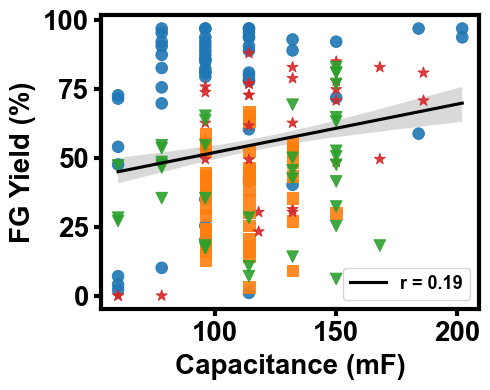

In [18]:
# relation of I_max and GY depend on material group. 
interest = "Cap"
fig, ax = plt.subplots(figsize=(5, 4))
markers = ['o', 's', '*', 'v']
colors=['blue', 'red', 'green', 'orange']

pearr = pearsonr(df[interest], df['Graphene_Yield'])
print (pearr)

sns1= sns.regplot(data=df, x=interest, y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=1, scatter=False,)# hue='Material')
#plt.legend(framealpha=1)

sns.scatterplot(data=df, x=interest, y='Graphene_Yield', 
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.9, s=70)

plt.xlabel(r'Capacitance (mF)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.legend(['r = {}'.format(round(pearr[0], 2))], frameon=True, fontsize=13)

plt.tight_layout()
plt.savefig('{}_GY.jpeg'.format(interest), dpi=500)

PearsonRResult(statistic=0.6163289914626963, pvalue=1.7732718188288054e-19)


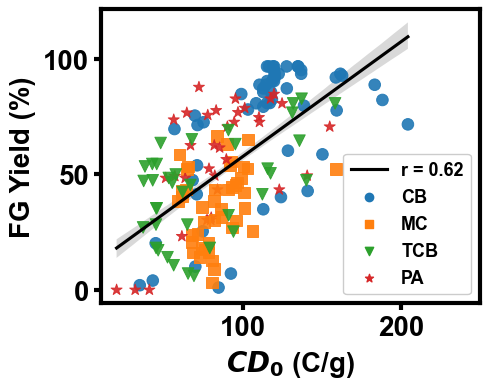

In [19]:
# relation of I_max and GY depend on material group. 
interest = "charge_density"
fig, ax = plt.subplots(figsize=(5, 4))
markers = ['o', 's', '*', 'v']
colors=['blue', 'red', 'green', 'orange']

pearr = pearsonr(df[interest], df['Graphene_Yield'])
print (pearr)

sns1= sns.regplot(data=df, x=interest, y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=1, scatter=False, label='r = {}'.format(round(pearr[0], 2)))# hue='Material')
plt.legend()
sns.scatterplot(data=df, x=interest, y='Graphene_Yield', 
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.9, s=70)
plt.legend(framealpha=0)
plt.xlabel(r'$CD_0$ (C/g)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.legend(framealpha=1, ncol=1, fontsize=13)
"""
plt.title("Pearson's r={}, p-value={}".format(round(pearr[0], 2), round(pearr[1], 3)), 
          loc='left', fontname='Arial', fontsize=17, pad=10,
          fontweight='bold', color='darkred') 
"""
plt.xlim(10, 250)
plt.tight_layout()
plt.savefig('{}_GY.jpeg'.format(interest), dpi=500)

<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
PearsonRResult(statistic=0.550739553986773, pvalue=1.360407442476544e-11)


/tmp/ipykernel_7485/3630775400.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


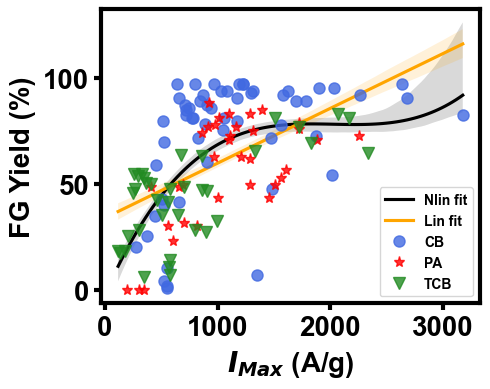

In [20]:
# relation of I_max and GY depend on material group. 
df_notMC = df.loc[df['Material'] !='MC']
fig, ax = plt.subplots(figsize=(5, 4))
sns1= sns.regplot(data=df_notMC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=3, scatter=False, label='Nlin fit')#hue='Material')
sns1.legend()
sns2= sns.regplot(data=df_notMC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "red"}, line_kws={"color": "orange"},
            ci=70, order=1, scatter=False, label='Lin fit')#hue='Material')
sns2.legend()
#plt.legend(handles=[sns1, sns2])
#plt.legend(['Lin fit'])
#plt.legend(('Nlin fit', '', 'Lin fit'), loc='upper left')

groups = df_notMC.groupby(['Material'])

markers = ['o', '*', 'v']
colors=['royalblue', 'red', 'forestgreen']

counter = 0
for name, group in groups:
    ax.plot(group.Norm_I_Max, group.Graphene_Yield, marker=markers[counter], alpha=0.8, color=colors[counter],
            linestyle='', ms=8, label=name)
    print (ax.artists)
    counter+=1
plt.legend(loc='lower right')

plt.xlabel(r'$I_{Max}$ (A/g)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('Imax_GY_notMC.jpeg', dpi=500)
print (pearsonr(df_notMC['Norm_I_Max'], df_notMC['Graphene_Yield']))

In [21]:
print (pearsonr(df_notMC['Norm_I_Max'].loc[df['Material']=='CB'], 
                df_notMC['Graphene_Yield'].loc[df['Material']=='CB']))
print (pearsonr(df_notMC['Norm_I_Max'].loc[df['Material']=='TCB'], 
                df_notMC['Graphene_Yield'].loc[df['Material']=='TCB']))
print (pearsonr(df_notMC['Norm_I_Max'].loc[df['Material']=='PA'], 
                df_notMC['Graphene_Yield'].loc[df['Material']=='PA']))

PearsonRResult(statistic=0.4111630285293328, pvalue=0.0014868819774603139)
PearsonRResult(statistic=0.6649516426132579, pvalue=7.147460801992074e-06)
PearsonRResult(statistic=0.6204594697210968, pvalue=7.005299233155058e-05)


PearsonRResult(statistic=0.2611109730168967, pvalue=0.08689789694650739)


/tmp/ipykernel_7485/1755551572.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


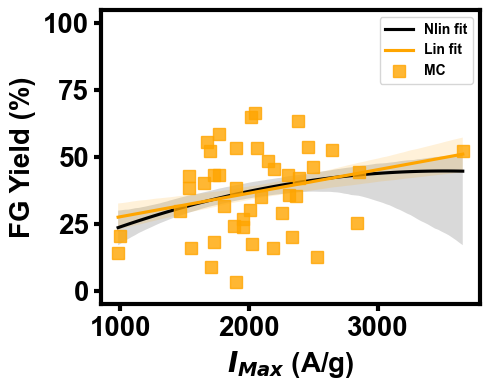

In [22]:
# relation of I_max and GY depend on material group. 
df_MC = df.loc[df['Material'] =='MC']
fig, ax = plt.subplots(figsize=(5, 4))
sns1 = sns.regplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=2, scatter=False, label='Nlin fit')#hue='Material')
sns1.legend()
sns2 = sns.regplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "orange"},
            ci=70, order=1, scatter=False, label='Lin fit')#hue='Material')
sns2.legend()
groups = df_MC.groupby(['Material'])

markers = ['s', ]
colors=['orange',]

counter = 0
for name, group in groups:
    ax.plot(group.Norm_I_Max, group.Graphene_Yield, marker=markers[counter], alpha=0.8, color='orange',
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(loc='upper right')
plt.ylim(-5, 105)

plt.xlabel(r'$I_{Max}$ (A/g)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('Imax_GY_MC.jpeg', dpi=500)
print (pearsonr(df_MC['Norm_I_Max'], df_MC['Graphene_Yield']))
#sns.lmplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', ci=0, order=1, hue="Material")
#plt.scatter (data=df_MC, x='Norm_I_Max', y='Graphene_Yield', hue='Material')#hue='Material')

GY is different for different material:  21.418942989646055 8.294709255926139e-12
Only the difference B/W MC and TCB is not significant:  26.345984960628492 1.582646385209848e-06


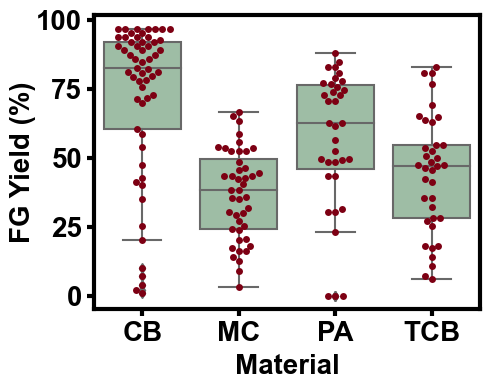

In [23]:
# distribution of Voltage for different materials
interest = 'Graphene_Yield'
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.boxplot(x='Material', y=interest, data=df, color='#99c2a2')
ax = sns.swarmplot(x="Material", y=interest, data=df, color='#7d0013')

plt.xlabel('Material', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=0)

ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('GY_diffMaterial.jpeg', dpi=500)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    df[interest].loc[df['Material']=='MC'], 
    df[interest].loc[df['Material']=='TCB'], 
    df[interest].loc[df['Material']=='PA']
)
print("GY is different for different material: ", fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    #df[interest].loc[df['Material']=='MC'], 
    #df[interest].loc[df['Material']=='PA'],
    df[interest].loc[df['Material']=='TCB'], 
    
)
print ('Only the difference B/W MC and TCB is not significant: ', fvalue, pvalue)

GY is different for different material:  99.29811508214692 4.257086195625861e-37
Only the difference B/W MC and TCB is not significant:  0.529377077688059 0.4687164736518864


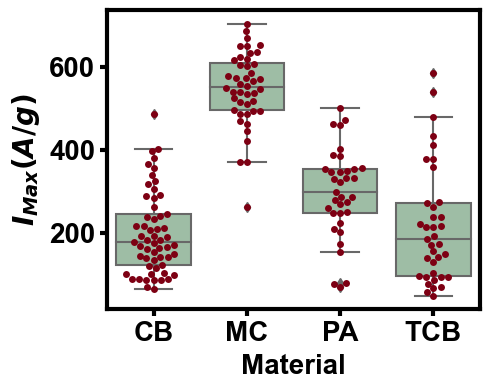

In [24]:
# distribution of Voltage for different materials
interest = 'I_Max'
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.boxplot(x='Material', y=interest, data=df, color='#99c2a2')
ax = sns.swarmplot(x="Material", y=interest, data=df, color='#7d0013')

plt.xlabel('Material', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('$I_{Max} (A/g)$', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('{}_diffMaterial.jpeg'.format(interest), dpi=500)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    df[interest].loc[df['Material']=='MC'], 
    df[interest].loc[df['Material']=='TCB'], 
    df[interest].loc[df['Material']=='PA']
)
print("GY is different for different material: ", fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    #df[interest].loc[df['Material']=='MC'], 
    #df[interest].loc[df['Material']=='PA'],
    df[interest].loc[df['Material']=='TCB'], 
    
)
print ('Only the difference B/W MC and TCB is not significant: ', fvalue, pvalue)

GY is different for different material:  40.81097745125515 6.85267534226327e-20
Only the difference B/W MC and TCB is not significant:  8.034435228689247 0.0056417012074060895


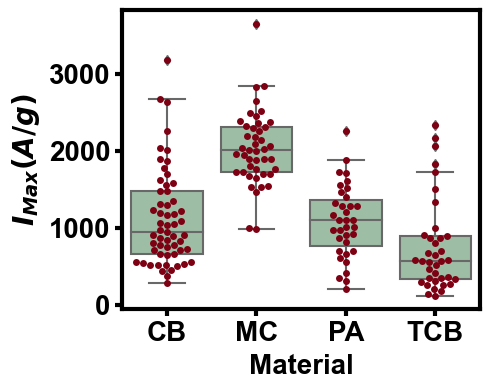

In [25]:
# distribution of Voltage for different materials
interest = 'Norm_I_Max'
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.boxplot(x='Material', y=interest, data=df, color='#99c2a2')
ax = sns.swarmplot(x="Material", y=interest, data=df, color='#7d0013')

plt.xlabel('Material', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('$I_{Max} (A/g)$', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('{}_diffMaterial.jpeg'.format(interest), dpi=500)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    df[interest].loc[df['Material']=='MC'], 
    df[interest].loc[df['Material']=='TCB'], 
    df[interest].loc[df['Material']=='PA']
)
print("GY is different for different material: ", fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    #df[interest].loc[df['Material']=='MC'], 
    #df[interest].loc[df['Material']=='PA'],
    df[interest].loc[df['Material']=='TCB'], 
    
)
print ('Only the difference B/W MC and TCB is not significant: ', fvalue, pvalue)

GY is different for different material:  2.9012095475966855 0.03653688125570461
Only the difference B/W MC and TCB is not significant:  1.404321313532881 0.239053494377123


/home/kianoosh/venv/ml/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kianoosh/venv/ml/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


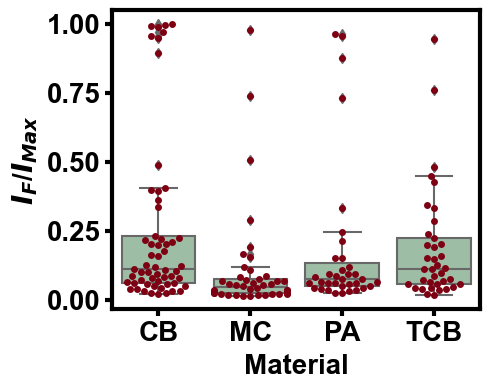

In [26]:
# distribution of Voltage for different materials
interest = 'Final_Current_Percent'
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.boxplot(x='Material', y=interest, data=df, color='#99c2a2')
ax = sns.swarmplot(x="Material", y=interest, data=df, color='#7d0013')

plt.xlabel('Material', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('$I_{F}$/$I_{Max}$', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('{}_diffMaterial.jpeg'.format(interest), dpi=500)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    df[interest].loc[df['Material']=='MC'], 
    df[interest].loc[df['Material']=='TCB'], 
    df[interest].loc[df['Material']=='PA']
)
print("GY is different for different material: ", fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    #df[interest].loc[df['Material']=='MC'], 
    #df[interest].loc[df['Material']=='PA'],
    df[interest].loc[df['Material']=='TCB'], 
    
)
print ('Only the difference B/W MC and TCB is not significant: ', fvalue, pvalue)

GY is different for different material:  16.058876069968367 3.127427912541107e-09
Only the difference B/W MC and TCB is not significant:  1.6200247741511082 0.20629545862492474


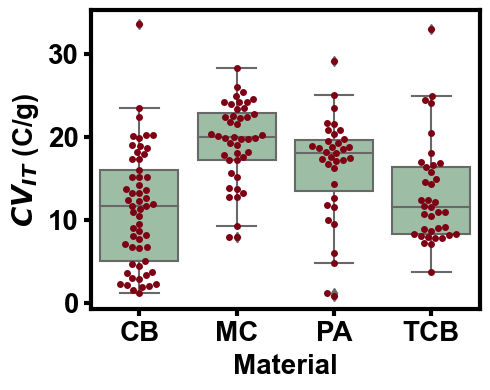

In [27]:
# distribution of Voltage for different materials
interest = 'Charge_Tot'
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.boxplot(x='Material', y=interest, data=df, color='#99c2a2')
ax = sns.swarmplot(x="Material", y=interest, data=df, color='#7d0013')

plt.xlabel('Material', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('$CV_{IT}$ (C/g)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('{}_diffMaterial.jpeg'.format(interest), dpi=500)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    df[interest].loc[df['Material']=='MC'], 
    df[interest].loc[df['Material']=='TCB'], 
    df[interest].loc[df['Material']=='PA']
)
print("GY is different for different material: ", fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    #df[interest].loc[df['Material']=='MC'], 
    #df[interest].loc[df['Material']=='PA'],
    df[interest].loc[df['Material']=='TCB'], 
    
)
print ('Only the difference B/W MC and TCB is not significant: ', fvalue, pvalue)

/tmp/ipykernel_7485/980499118.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  labels = df.groupby('Material').mean().index.array
/tmp/ipykernel_7485/980499118.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Ra_means = df.groupby('Material').mean()['Graphene_Yield'].values
/tmp/ipykernel_7485/980499118.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Ra_std = df.groupby('Material').std()['Graphene_Yield'].v

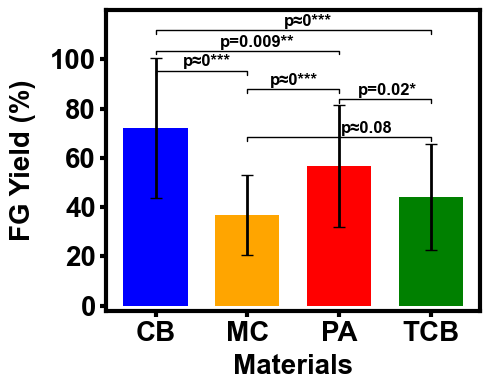

In [28]:
ind  = np.arange(4)    # the x locations for the groups
width= 0.7
labels = df.groupby('Material').mean().index.array

# Pull the formatting out here
bar_kwargs = {'width':width,'linewidth':2,'zorder':5}
err_kwargs = {'zorder':5,'fmt':'none','linewidth':2,'ecolor':'k'}  #for matplotlib >= v1.4 use 'fmt':'none' instead


Ra_means = df.groupby('Material').mean()['Graphene_Yield'].values
Ra_std = df.groupby('Material').std()['Graphene_Yield'].values

fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(axis='x', length=4, width=3, colors='black', grid_alpha=0, labelsize='20')
ax.tick_params(axis='y', length=4, width=3, colors='black', grid_alpha=0, labelsize='20')

ax.p1 = plt.bar(ind, Ra_means, color=['blue', 'orange' , 'red', 'green'], **bar_kwargs)
ax.errs = plt.errorbar(ind, Ra_means, yerr=Ra_std, capsize=4, **err_kwargs)


# Custom function to draw the diff bars

def label_diff(i, j, text, X, Y, count):
    x = (X[i] + X[j])/2
    y = max(Y[i], Y[j])
    dx = abs(X[i] - X[j])

    props0 = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':17,'shrinkB':17,'linewidth':1}
    props1 = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':37,'shrinkB':37,'linewidth':1}
    props2 = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':57,'shrinkB':57,'linewidth':1}
    props3 = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':17,'shrinkB':17,'linewidth':1}
    props4 = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':37,'shrinkB':37,'linewidth':1}
    props5 = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':17,'shrinkB':17,'linewidth':1}
    
    if count==0:
        ax.annotate(text, xy=(x-0.2,y+25), zorder=10, fontsize=12, fontweight='bold')
        ax.annotate('', xy=(X[i], y+12), xytext=(X[j], y+12), arrowprops=props0)
    elif count==1:
        ax.annotate(text, xy=(x-0.3,y+33), zorder=10, fontsize=12, fontweight='bold')
        ax.annotate('', xy=(X[i], y+9), xytext=(X[j], y+9), arrowprops=props1)
    elif count==2:
        ax.annotate(text, xy=(x-0.1,y+41.5), zorder=1, fontsize=12, fontweight='bold')
        ax.annotate('', xy=(X[i], y+6), xytext=(X[j], y+6), arrowprops=props2)
    elif count==3:
        ax.annotate(text, xy=(x-0.25,y+33), zorder=10, fontsize=12, fontweight='bold')
        ax.annotate('', xy=(X[i], y+20), xytext=(X[j], y+20), arrowprops=props3)
    elif count==4:
        ax.annotate(text, xy=(x+0.02,y+26), zorder=10, fontsize=12, fontweight='bold')
        ax.annotate('', xy=(X[i], y+2), xytext=(X[j], y+2), arrowprops=props4)        
    else:
        ax.annotate(text, xy=(x-0.3,y+29), zorder=10, fontsize=12, fontweight='bold')
        ax.annotate('', xy=(X[i], y+16), xytext=(X[j], y+16), arrowprops=props5)   

# Call the function

label_diff(0, 1,'p≈0***', ind, Ra_means, 0)
label_diff(0, 2,'p=0.009**', ind, Ra_means, 1)
label_diff(0, 3,'p≈0***', ind, Ra_means, 2)
label_diff(1, 2,'p≈0***', ind, Ra_means, 3)
label_diff(1, 3,'p≈0.08', ind, Ra_means, 4)
label_diff(2, 3,'p=0.02*', ind, Ra_means, 5)

#label_diff(1, 3,'p < 0.001***',ind, Ra_means)
#label_diff(2,3,'p=0.0025',ind,Ra_means)

plt.xlabel('Materials', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=10)

[i.set_linewidth(3) for i in ax.spines.values()]

plt.ylim(ymax=120)
plt.ylim(ymin=-2)
plt.yticks((0, 20, 40, 60, 80, 100))
plt.xticks(ind, labels, color='k')
plt.tight_layout()

plt.savefig ('GY_diffMaterial_pval.jpeg', dpi=500)

/tmp/ipykernel_7485/422521751.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot (GY_CB, color='blue', hist=False, bins=bins, )#norm_hist=True)
/tmp/ipykernel_7485/422521751.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot (GY_MC, color='orange', hist=False, bins=bins)
/t

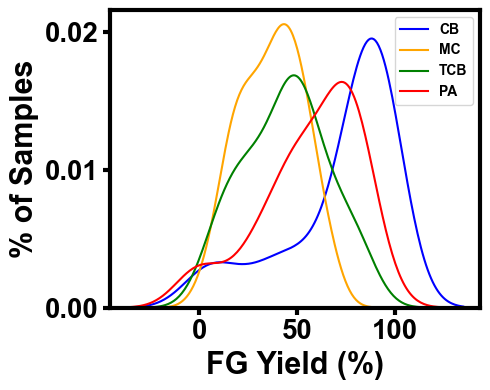

In [29]:
GY_CB = np.array (df['Graphene_Yield'].loc[df['Material'] =='CB']).reshape(-1, 1)
GY_MC = np.array (df['Graphene_Yield'].loc[df['Material'] =='MC']).reshape(-1, 1)
GY_PA = np.array (df['Graphene_Yield'].loc[df['Material'] =='PA']).reshape(-1, 1)
GY_TCB = np.array (df['Graphene_Yield'].loc[df['Material'] =='TCB']).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', 
               grid_alpha=0, labelsize='20')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', 
               grid_alpha=0, labelsize='20')
plt.xlabel('FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
plt.ylabel('% of Samples', fontsize='22', fontname='Arial', fontweight='bold')

bins = np.linspace(np.min(GY_CB), np.max(GY_CB), 20)
sns.distplot (GY_CB, color='blue', hist=False, bins=bins, )#norm_hist=True)

bins = np.linspace(np.min(GY_MC), np.max(GY_MC), 20)
sns.distplot (GY_MC, color='orange', hist=False, bins=bins)

bins = np.linspace(np.min(GY_TCB), np.max(GY_TCB), 20)
sns.distplot (GY_TCB, color='green', hist=False, bins=bins) 

bins = np.linspace(np.min(GY_PA), np.max(GY_PA), 20)
sns.distplot (GY_PA, color='red', hist=False, bins=bins)


[i.set_linewidth(3) for i in ax.spines.values()]

plt.yticks((0.0, 0.01, 0.02))
plt.legend(['CB', 'MC', 'TCB', 'PA'])
plt.tight_layout()
plt.savefig('hist_GY_materials.jpeg', dpi=500)

In [30]:
# RF Regression result
r_squareds_global_rfr = []
RMSEs_global_rfr = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
rgboost_rands = np.array (([94, 498, 482], [881, 344, 243], 
                          [66, 855, 905], [500, 800, 340], [840, 400, 500]))

for glob_split in pbar(range(global_split_rand, global_split_rand + 5)):
    #### Materials coef. for 3 time-current properties
    #print ('#### material coef. for 3 current properties')
    ## material coef. Final_Current_Percent
    input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                     Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Final_Current_Percent, test_size=0.2, random_state=glob_split)
    
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_IfImax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_IfImax: ', pearr[0])
    
    ## material coef. I_max normalized
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_I_Max, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_Imax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_Imax: ', pearr[0])
    
    ## material coef.  Norm_charge_tot
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_charge_tot, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_chargetot: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_chargetot: ', pearr[0])
    material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
    material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
    material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot
    
    #### proxy RF Final_Current_percent
    new_features = np.concatenate ((charge_denisty, pulsetime,
                                    material_type_I_Finalperc_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                          train_test_split(new_features, Final_Current_Percent, df['Material'],
                                         indices, test_size = 0.20, random_state = glob_split)
    rfr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                       learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                       random_state=rgboost_rands[counter, 0])
    
    rfr_final_I_percent.fit(train_new_features, train_labels)
    Final_Current_Percent_predicted = rfr_final_I_percent.predict(new_features)  
    y_pred = rfr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, y_pred)
    #print('r2 score = ', r_squared_Final_Current_test)
    pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
    #print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

    #### proxy RF Norm_I_Max
    new_features = np.concatenate ((charge_denisty,
                                    pulsetime, material_type_Norm_I_Max_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_I_Max, 
                                           indices, test_size = 0.2, random_state = glob_split)  
    rfr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                       learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                      random_state=rgboost_rands[counter, 1])
    
    rfr_norm_I_max.fit(train_new_features, train_labels);
    Norm_I_Max_predicted = rfr_norm_I_max.predict(new_features)
    Norm_I_Max_test = rfr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    #print('r2 score for test = ', r_squared_Norm_I_Max_test)
    pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
    #print('pearson r for test= ', pr_Norm_I_Max_test[0])
    
    #### proxy RF Norm_Norm_charge_tot
    #print ('#### proxy RF Norm_Norm_charge_tot')
    new_features = np.concatenate ((charge_denisty,pulsetime,
                                    material_type_Norm_charge_Tot_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_charge_tot, 
                                           indices, test_size = 0.20, random_state = glob_split)
    rfr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
                  random_state=rgboost_rands[counter, 2])
 
    rfr_norm_charge_total.fit(train_new_features, train_labels)
    Norm_charge_tot_predicted = rfr_norm_charge_total.predict(new_features)
    Norm_charge_tot_test = rfr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    #print('r2 score for test= ', r_squared_Norm_charge_tot_test)
    pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
    #print('pearson r for test= ', pr_Norm_charge_tot_test[0])
    
    #### FINAL prediction of Graphene Yield
    CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
    resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
    heat_power = np.array (df['Voltage']*df['Voltage']/(resistance_matrix**1)*df['PulseTime']*(1e-6)).reshape(-1, 1)
    CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                                 CB_MC_PA_coef_Norm_I_Max +
                                 CB_MC_PA_coef_Norm_charge_tot)/3

    material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
    new_features = np.concatenate ((charge_denisty, 
                                    X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                    #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                    #material_type_GY_coef,
                                    pulsetime,
                                    Pretreat_voltage,
                                    (np.array (df['temp2']).reshape(-1, 1))/1000,
                                    atmosphere_type,
                                    Final_Current_Percent_predicted.reshape(-1, 1),
                                    Norm_I_Max_predicted.reshape(-1, 1),
                                    Norm_charge_tot_predicted.reshape(-1, 1), 
                                    heat_power.reshape(-1, 1)), axis=1)
    test_size = 0.2
    indices = np.arange(len(new_features))
    labels = Graphene_Yield
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                          train_test_split(new_features, labels, 
                                           indices, test_size = test_size, random_state=glob_split)
    r_squareds = list()
    RMSEs_rfr = list()
    r_squareds_randomized_testtrain = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    r2_max = 0
    test_split_seed1 = glob_split
    test_split_seed2 = glob_split + 1
    test_split_count = test_split_seed2 - test_split_seed1
    rep=10
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    # rand = 499 with max of:  0.79
    for random_state in range (499, 500):
        # Instantiate model with 1000 decision trees
        rfr_graphyield = RandomForestRegressor(max_depth=4, n_estimators=50, 
                                              random_state=random_state, min_samples_split=5)
        # Train the model on training data
        rfr_graphyield.fit(train_new_features, train_labels);
        predictions = rfr_graphyield.predict(test_new_features)
        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
        RMSEs_rfr.append (np.sqrt (mean_squared_error(predictions, test_labels)))
    #m = tf.keras.metrics.RootMeanSquaredError()
    pred_test = predictions
    #m.update_state(pred_test, test_labels)
    #print ('RMSE for test, ', m.result().numpy())
    r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
    #print ('all r2: ', r_squareds_randomized_testtrain_vec)
    r_squareds_global_rfr.append(r_squareds)
    RMSEs_global_rfr.append (RMSEs_rfr)
    list_glob_rand_state.append(glob_split)
    counter += 1

print ('R2: ', np.mean(r_squareds_global_rfr))
print ('RMSE: ', np.mean(RMSEs_global_rfr))
end = time.time()
print ('time is : ', end-start)

/tmp/ipykernel_7485/2978716571.py:171: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_7485/2978716571.py:171: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_7485/2978716571.py:171: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_7485/2978716571.py:171: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_graphyield.fit(train_new_features, train_labels);


R2:  0.7567409638213574
RMSE:  13.613112746096087
time is :  0.2965555191040039


In [31]:
# RF Regression result
r_squareds_global_lr = []
RMSEs_global_lr = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
rgboost_rands = np.array (([94, 498, 482], [881, 344, 243], 
                          [66, 855, 905], [500, 800, 340], [840, 400, 500]))

for glob_split in pbar(range(global_split_rand, global_split_rand+5)):
    #### Materials coef. for 3 time-current properties
    #print ('#### material coef. for 3 current properties')
    ## material coef. Final_Current_Percent
    input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                     Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Final_Current_Percent, test_size=0.2, random_state=glob_split)
    
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_IfImax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_IfImax: ', pearr[0])
    
    ## material coef. I_max normalized
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_I_Max, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_Imax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_Imax: ', pearr[0])
    
    ## material coef.  Norm_charge_tot
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_charge_tot, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_chargetot: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_chargetot: ', pearr[0])
    material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
    material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
    material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot
    
    #### proxy RF Final_Current_percent
    new_features = np.concatenate ((charge_denisty, pulsetime,
                                    material_type_I_Finalperc_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                          train_test_split(new_features, Final_Current_Percent, df['Material'],
                                         indices, test_size = 0.20, random_state = glob_split)
    lr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                       learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                       random_state=rgboost_rands[counter, 0])
    
    lr_final_I_percent.fit(train_new_features, train_labels)
    Final_Current_Percent_predicted = lr_final_I_percent.predict(new_features)  
    y_pred = lr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, y_pred)
    #print('r2 score = ', r_squared_Final_Current_test)
    pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
    #print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

    #### proxy RF Norm_I_Max
    new_features = np.concatenate ((charge_denisty,
                                    pulsetime, material_type_Norm_I_Max_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_I_Max, 
                                           indices, test_size = 0.2, random_state = glob_split)  
    lr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                       learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                      random_state=rgboost_rands[counter, 1])
    
    lr_norm_I_max.fit(train_new_features, train_labels);
    Norm_I_Max_predicted = lr_norm_I_max.predict(new_features)
    Norm_I_Max_test = lr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    #print('r2 score for test = ', r_squared_Norm_I_Max_test)
    pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
    #print('pearson r for test= ', pr_Norm_I_Max_test[0])
    
    #### proxy RF Norm_Norm_charge_tot
    #print ('#### proxy RF Norm_Norm_charge_tot')
    new_features = np.concatenate ((charge_denisty,pulsetime,
                                    material_type_Norm_charge_Tot_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_charge_tot, 
                                           indices, test_size = 0.20, random_state = glob_split)
    lr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
                  random_state=rgboost_rands[counter, 2])
 
    lr_norm_charge_total.fit(train_new_features, train_labels)
    Norm_charge_tot_predicted = lr_norm_charge_total.predict(new_features)
    Norm_charge_tot_test = lr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    #print('r2 score for test= ', r_squared_Norm_charge_tot_test)
    pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
    #print('pearson r for test= ', pr_Norm_charge_tot_test[0])
    
    #### FINAL prediction of Graphene Yield
    CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
    resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
    heat_power = np.array (df['Voltage']*df['Voltage']/(resistance_matrix**1)*df['PulseTime']*(1e-6)).reshape(-1, 1)
    CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                                 CB_MC_PA_coef_Norm_I_Max +
                                 CB_MC_PA_coef_Norm_charge_tot)/3

    material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
    new_features = np.concatenate ((charge_denisty, 
                                    X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                    #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                    #material_type_GY_coef,
                                    pulsetime,
                                    Pretreat_voltage,
                                    (np.array (df['temp2']).reshape(-1, 1))/1000,
                                    atmosphere_type,
                                    Final_Current_Percent_predicted.reshape(-1, 1),
                                    Norm_I_Max_predicted.reshape(-1, 1),
                                    Norm_charge_tot_predicted.reshape(-1, 1), 
                                    heat_power.reshape(-1, 1)), axis=1)
    test_size = 0.2
    indices = np.arange(len(new_features))
    labels = Graphene_Yield
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                          train_test_split(new_features, labels, 
                                           indices, test_size = test_size, random_state=glob_split)
    r_squareds = list()
    RMSEs_lr = list()
    r_squareds_randomized_testtrain = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    r2_max = 0
    test_split_seed1 = glob_split
    test_split_seed2 = glob_split + 1
    test_split_count = test_split_seed2 - test_split_seed1
    rep=10
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    # rand = 499 with max of:  0.79
    for random_state in range (499, 500):
        # Instantiate model with 1000 decision trees
        lr_graphyield = linear_model.LinearRegression()
        # Train the model on training data
        lr_graphyield.fit(train_new_features, train_labels);
        predictions = lr_graphyield.predict(test_new_features)
        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
        RMSEs_lr.append (np.sqrt (mean_squared_error(predictions, test_labels)))
    #m = tf.keras.metrics.RootMeanSquaredError()
    pred_test = predictions
    #m.update_state(pred_test, test_labels)
    #print ('RMSE for test, ', m.result().numpy())
    r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
    #print ('all r2: ', r_squareds_randomized_testtrain_vec)
    r_squareds_global_lr.append(r_squareds)
    list_glob_rand_state.append(glob_split)
    RMSEs_global_lr.append (RMSEs_lr)
    counter += 1

print ('R2: ', np.mean(r_squareds_global_lr))
print ('RMSE: ', np.mean(RMSEs_global_lr))
end = time.time()
print ('time is : ', end-start)

R2:  0.6319054008892788
RMSE:  16.810350956577004
time is :  0.16265130043029785


In [32]:
# RF Regression result
r_squareds_global_br = []
list_glob_rand_state = []
RMSEs_global_br = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
rgboost_rands = np.array (([94, 498, 482], [881, 344, 243], 
                          [66, 855, 905], [500, 800, 340], [840, 400, 500]))

for glob_split in pbar(range(global_split_rand, global_split_rand+5)):
    #### Materials coef. for 3 time-current properties
    #print ('#### material coef. for 3 current properties')
    ## material coef. Final_Current_Percent
    input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                     Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Final_Current_Percent, test_size=0.2, random_state=glob_split)
    
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_IfImax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_IfImax: ', pearr[0])
    
    ## material coef. I_max normalized
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_I_Max, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_Imax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_Imax: ', pearr[0])
    
    ## material coef.  Norm_charge_tot
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_charge_tot, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_chargetot: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_chargetot: ', pearr[0])
    material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
    material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
    material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot
    
    #### proxy RF Final_Current_percent
    new_features = np.concatenate ((charge_denisty, pulsetime,
                                    material_type_I_Finalperc_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                          train_test_split(new_features, Final_Current_Percent, df['Material'],
                                         indices, test_size = 0.20, random_state = glob_split)
    br_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                       learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                       random_state=rgboost_rands[counter, 0])
    
    br_final_I_percent.fit(train_new_features, train_labels)
    Final_Current_Percent_predicted = br_final_I_percent.predict(new_features)  
    y_pred = br_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, y_pred)
    #print('r2 score = ', r_squared_Final_Current_test)
    pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
    #print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

    #### proxy RF Norm_I_Max
    new_features = np.concatenate ((charge_denisty,
                                    pulsetime, material_type_Norm_I_Max_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_I_Max, 
                                           indices, test_size = 0.2, random_state = glob_split)  
    br_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                       learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                      random_state=rgboost_rands[counter, 1])
    
    br_norm_I_max.fit(train_new_features, train_labels);
    Norm_I_Max_predicted = br_norm_I_max.predict(new_features)
    Norm_I_Max_test = br_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    #print('r2 score for test = ', r_squared_Norm_I_Max_test)
    pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
    #print('pearson r for test= ', pr_Norm_I_Max_test[0])
    
    #### proxy RF Norm_Norm_charge_tot
    #print ('#### proxy RF Norm_Norm_charge_tot')
    new_features = np.concatenate ((charge_denisty,pulsetime,
                                    material_type_Norm_charge_Tot_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_charge_tot, 
                                           indices, test_size = 0.20, random_state = glob_split)
    br_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
                  random_state=rgboost_rands[counter, 2])
 
    br_norm_charge_total.fit(train_new_features, train_labels)
    Norm_charge_tot_predicted = br_norm_charge_total.predict(new_features)
    Norm_charge_tot_test = br_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    #print('r2 score for test= ', r_squared_Norm_charge_tot_test)
    pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
    #print('pearson r for test= ', pr_Norm_charge_tot_test[0])
    
    #### FINAL prediction of Graphene Yield
    CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
    resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
    heat_power = np.array (df['Voltage']*df['Voltage']/(resistance_matrix**1)*df['PulseTime']*(1e-6)).reshape(-1, 1)
    CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                                 CB_MC_PA_coef_Norm_I_Max +
                                 CB_MC_PA_coef_Norm_charge_tot)/3

    material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
    new_features = np.concatenate ((charge_denisty, 
                                    X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                    #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                    #material_type_GY_coef,
                                    pulsetime,
                                    Pretreat_voltage,
                                    (np.array (df['temp2']).reshape(-1, 1))/1000,
                                    atmosphere_type,
                                    Final_Current_Percent_predicted.reshape(-1, 1),
                                    Norm_I_Max_predicted.reshape(-1, 1),
                                    Norm_charge_tot_predicted.reshape(-1, 1), 
                                    heat_power.reshape(-1, 1)), axis=1)
    test_size = 0.2
    indices = np.arange(len(new_features))
    labels = Graphene_Yield
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                          train_test_split(new_features, labels, 
                                           indices, test_size = test_size, random_state=glob_split)
    r_squareds = list()
    r_squareds_randomized_testtrain = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    r2_max = 0
    test_split_seed1 = glob_split
    test_split_seed2 = glob_split + 1
    test_split_count = test_split_seed2 - test_split_seed1
    rep=10
    r_squareds = list()
    RMSEs_br = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    # rand = 499 with max of:  0.79
    for random_state in range (499, 500):
        # Instantiate model with 1000 decision trees
        br_graphyield = linear_model.BayesianRidge(n_iter=1000, tol=1e-5)
        # Train the model on training data
        br_graphyield.fit(train_new_features, train_labels);
        predictions = br_graphyield.predict(test_new_features)
        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
        RMSEs_br.append (np.sqrt (mean_squared_error(predictions, test_labels)))
    #m = tf.keras.metrics.RootMeanSquaredError()
    pred_test = predictions
    #m.update_state(pred_test, test_labels)
    #print ('RMSE for test, ', m.result().numpy())
    r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
    #print ('all r2: ', r_squareds_randomized_testtrain_vec)
    r_squareds_global_br.append(r_squareds)
    RMSEs_global_br.append(RMSEs_br)
    list_glob_rand_state.append(glob_split)
    counter += 1

print ('R2: ', np.mean(r_squareds_global_br))
print ('RMSE: ', np.mean(RMSEs_global_br))
end = time.time()
print ('time is : ', end-start)

/home/kianoosh/venv/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/venv/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/venv/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/venv/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

R2:  0.6296000983346043
RMSE:  16.80476872293502
time is :  0.21594715118408203


In [33]:
# RF Regression result
r_squareds_global_dt = []
RMSEs_global_dt = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
rgboost_rands = np.array (([94, 498, 482], [881, 344, 243], 
                          [66, 855, 905], [500, 800, 340], [840, 400, 500]))

for glob_split in pbar(range(global_split_rand, global_split_rand+5)):
    #### Materials coef. for 3 time-current properties
    #print ('#### material coef. for 3 current properties')
    ## material coef. Final_Current_Percent
    input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                     Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Final_Current_Percent, test_size=0.2, random_state=glob_split)
    
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_IfImax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_IfImax: ', pearr[0])
    
    ## material coef. I_max normalized
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_I_Max, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_Imax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_Imax: ', pearr[0])
    
    ## material coef.  Norm_charge_tot
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_charge_tot, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_chargetot: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_chargetot: ', pearr[0])
    material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
    material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
    material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot
    
    #### proxy RF Final_Current_percent
    new_features = np.concatenate ((charge_denisty, pulsetime,
                                    material_type_I_Finalperc_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                          train_test_split(new_features, Final_Current_Percent, df['Material'],
                                         indices, test_size = 0.20, random_state = glob_split)
    dt_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                       learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                       random_state=rgboost_rands[counter, 0])
    
    dt_final_I_percent.fit(train_new_features, train_labels)
    Final_Current_Percent_predicted = dt_final_I_percent.predict(new_features)  
    y_pred = dt_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, y_pred)
    #print('r2 score = ', r_squared_Final_Current_test)
    pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
    #print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

    #### proxy RF Norm_I_Max
    new_features = np.concatenate ((charge_denisty,
                                    pulsetime, material_type_Norm_I_Max_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_I_Max, 
                                           indices, test_size = 0.2, random_state = glob_split)  
    dt_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                       learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                      random_state=rgboost_rands[counter, 1])
    
    dt_norm_I_max.fit(train_new_features, train_labels);
    Norm_I_Max_predicted = dt_norm_I_max.predict(new_features)
    Norm_I_Max_test = dt_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    #print('r2 score for test = ', r_squared_Norm_I_Max_test)
    pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
    #print('pearson r for test= ', pr_Norm_I_Max_test[0])
    
    #### proxy RF Norm_Norm_charge_tot
    #print ('#### proxy RF Norm_Norm_charge_tot')
    new_features = np.concatenate ((charge_denisty,pulsetime,
                                    material_type_Norm_charge_Tot_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_charge_tot, 
                                           indices, test_size = 0.20, random_state = glob_split)
    dt_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
                  random_state=rgboost_rands[counter, 2])
 
    dt_norm_charge_total.fit(train_new_features, train_labels)
    Norm_charge_tot_predicted = dt_norm_charge_total.predict(new_features)
    Norm_charge_tot_test = dt_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    #print('r2 score for test= ', r_squared_Norm_charge_tot_test)
    pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
    #print('pearson r for test= ', pr_Norm_charge_tot_test[0])
    
    #### FINAL prediction of Graphene Yield
    CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
    resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
    heat_power = np.array (df['Voltage']*df['Voltage']/(resistance_matrix**1)*df['PulseTime']*(1e-6)).reshape(-1, 1)
    CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                                 CB_MC_PA_coef_Norm_I_Max +
                                 CB_MC_PA_coef_Norm_charge_tot)/3

    material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
    new_features = np.concatenate ((charge_denisty, 
                                    X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                    #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                    #material_type_GY_coef,
                                    pulsetime,
                                    Pretreat_voltage,
                                    (np.array (df['temp2']).reshape(-1, 1))/1000,
                                    atmosphere_type,
                                    Final_Current_Percent_predicted.reshape(-1, 1),
                                    Norm_I_Max_predicted.reshape(-1, 1),
                                    Norm_charge_tot_predicted.reshape(-1, 1), 
                                    heat_power.reshape(-1, 1)), axis=1)
    test_size = 0.2
    indices = np.arange(len(new_features))
    labels = Graphene_Yield
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                          train_test_split(new_features, labels, 
                                           indices, test_size = test_size, random_state=glob_split)
    r_squareds = list()
    r_squareds_randomized_testtrain = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    r2_max = 0
    test_split_seed1 = glob_split
    test_split_seed2 = glob_split + 1
    test_split_count = test_split_seed2 - test_split_seed1
    rep=10
    r_squareds = list()
    RMSEs_dt = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    # rand = 499 with max of:  0.79
    for random_state in range (499, 500):
        # Instantiate model with 1000 decision trees
        dt_graphyield = DecisionTreeRegressor(max_depth=3, min_samples_split=3, random_state=random_state)
        # Train the model on training data
        dt_graphyield.fit(train_new_features, train_labels);
        predictions = dt_graphyield.predict(test_new_features)
        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
        RMSEs_dt.append (np.sqrt (mean_squared_error(predictions, test_labels)))
    #m = tf.keras.metrics.RootMeanSquaredError()
    pred_test = predictions
    #m.update_state(pred_test, test_labels)
    #print ('RMSE for test, ', m.result().numpy())
    r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
    #print ('all r2: ', r_squareds_randomized_testtrain_vec)
    r_squareds_global_dt.append(r_squareds)
    list_glob_rand_state.append(glob_split)
    RMSEs_global_dt.append(RMSEs_dt)
    counter += 1

print (np.mean(r_squareds_global_dt))
print (np.mean(RMSEs_global_dt))
end = time.time()
print ('time is : ', end-start)

0.6269265091446858
16.89782061516806
time is :  0.15450620651245117


In [34]:
# RF Regression result
r_squareds_global_mlp = []
RMSEs_global_mlp = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
rgboost_rands = np.array (([94, 498, 482], [881, 344, 243], 
                          [66, 855, 905], [500, 800, 340], [840, 400, 500]))

for glob_split in pbar(range(global_split_rand, global_split_rand+5)):
    #### Materials coef. for 3 time-current properties
    #print ('#### material coef. for 3 current properties')
    ## material coef. Final_Current_Percent
    input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                     Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Final_Current_Percent, test_size=0.2, random_state=glob_split)
    
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_IfImax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_IfImax: ', pearr[0])
    
    ## material coef. I_max normalized
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_I_Max, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_Imax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_Imax: ', pearr[0])
    
    ## material coef.  Norm_charge_tot
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_charge_tot, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_chargetot: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_chargetot: ', pearr[0])
    material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
    material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
    material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot
    
    #### proxy RF Final_Current_percent
    new_features = np.concatenate ((charge_denisty, pulsetime,
                                    material_type_I_Finalperc_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                          train_test_split(new_features, Final_Current_Percent, df['Material'],
                                         indices, test_size = 0.20, random_state = glob_split)
    mlp_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                       learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                       random_state=rgboost_rands[counter, 0])
    
    mlp_final_I_percent.fit(train_new_features, train_labels)
    Final_Current_Percent_predicted = mlp_final_I_percent.predict(new_features)  
    y_pred = mlp_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, y_pred)
    #print('r2 score = ', r_squared_Final_Current_test)
    pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
    #print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

    #### proxy RF Norm_I_Max
    new_features = np.concatenate ((charge_denisty,
                                    pulsetime, material_type_Norm_I_Max_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_I_Max, 
                                           indices, test_size = 0.2, random_state = glob_split)  
    mlp_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                       learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                      random_state=rgboost_rands[counter, 1])
    
    mlp_norm_I_max.fit(train_new_features, train_labels);
    Norm_I_Max_predicted = mlp_norm_I_max.predict(new_features)
    Norm_I_Max_test = mlp_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    #print('r2 score for test = ', r_squared_Norm_I_Max_test)
    pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
    #print('pearson r for test= ', pr_Norm_I_Max_test[0])
    
    #### proxy RF Norm_Norm_charge_tot
    #print ('#### proxy RF Norm_Norm_charge_tot')
    new_features = np.concatenate ((charge_denisty,pulsetime,
                                    material_type_Norm_charge_Tot_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_charge_tot, 
                                           indices, test_size = 0.20, random_state = glob_split)
    mlp_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
                  random_state=rgboost_rands[counter, 2])
 
    mlp_norm_charge_total.fit(train_new_features, train_labels)
    Norm_charge_tot_predicted = mlp_norm_charge_total.predict(new_features)
    Norm_charge_tot_test = mlp_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    #print('r2 score for test= ', r_squared_Norm_charge_tot_test)
    pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
    #print('pearson r for test= ', pr_Norm_charge_tot_test[0])
    
    #### FINAL prediction of Graphene Yield
    CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
    resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
    heat_power = np.array (df['Voltage']*df['Voltage']/(resistance_matrix**1)*df['PulseTime']*(1e-6)).reshape(-1, 1)
    CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                                 CB_MC_PA_coef_Norm_I_Max +
                                 CB_MC_PA_coef_Norm_charge_tot)/3

    material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
    new_features = np.concatenate ((charge_denisty, 
                                    X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                    #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                    #material_type_GY_coef,
                                    pulsetime,
                                    Pretreat_voltage,
                                    (np.array (df['temp2']).reshape(-1, 1))/1000,
                                    atmosphere_type,
                                    Final_Current_Percent_predicted.reshape(-1, 1),
                                    Norm_I_Max_predicted.reshape(-1, 1),
                                    Norm_charge_tot_predicted.reshape(-1, 1), 
                                    heat_power.reshape(-1, 1)), axis=1)
    test_size = 0.2
    indices = np.arange(len(new_features))
    labels = Graphene_Yield
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                          train_test_split(new_features, labels, 
                                           indices, test_size = test_size, random_state=glob_split)
    r_squareds = list()
    r_squareds_randomized_testtrain = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    r2_max = 0
    test_split_seed1 = glob_split
    test_split_seed2 = glob_split + 1
    test_split_count = test_split_seed2 - test_split_seed1
    rep=10
    r_squareds = list()
    RMSEs_mlp = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    # rand = 499 with max of:  0.79
    for random_state in range (499, 500):
        # Instantiate model with 1000 decision trees
        mlp_graphyield = MLPRegressor(hidden_layer_sizes=(100, 100, 100), activation='relu', 
                   alpha=0.05, learning_rate = 'adaptive', solver='adam', random_state=random_state)
        # Train the model on training data
        mlp_graphyield.fit(train_new_features, train_labels);
        predictions = mlp_graphyield.predict(test_new_features)
        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
        RMSEs_mlp.append (np.sqrt (mean_squared_error(predictions, test_labels)))
    #m = tf.keras.metrics.RootMeanSquaredError()
    pred_test = predictions
    #m.update_state(pred_test, test_labels)
    #print ('RMSE for test, ', m.result().numpy())
    r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
    #print ('all r2: ', r_squareds_randomized_testtrain_vec)
    r_squareds_global_mlp.append(r_squareds)
    list_glob_rand_state.append(glob_split)
    RMSEs_global_mlp.append(RMSEs_mlp)
    counter += 1

print ('R2: ', np.mean (r_squareds_global_mlp))
print ('RMSE: ', np.mean (RMSEs_global_mlp))
end = time.time()
print ('time is : ', end-start)

/home/kianoosh/venv/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/venv/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kianoosh/venv/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/venv/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

R2:  0.5920669291579305
RMSE:  17.547674159097586
time is :  1.6807255744934082


In [35]:
global_split_rand

2571

In [36]:
# XGBoost Regression result
r_squareds_global_xgbr = []
r_squareds_train_global_xgbr = []
importances_global = []
RMSEs_global_xgbr = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
# best split 100, 105
rgboost_rands = np.array (([ 30, 470, 938], [881, 652, 515], 
                           [247, 374, 905], [314, 31, 746], [996, 405, 931]))
#rgboost_rands[:,:] = 94
for glob_split in pbar(range(global_split_rand, global_split_rand + 5)):
    #### Materials coef. for 3 time-current properties
    #print ('#### material coef. for 3 current properties')
    ## material coef. Final_Current_Percent
    input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                     Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Final_Current_Percent, test_size=0.2, random_state=glob_split)
    
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_IfImax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_IfImax: ', pearr[0])
    
    ## material coef. I_max normalized
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_I_Max, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_Imax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_Imax: ', pearr[0])
    
    ## material coef.  Norm_charge_tot
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_charge_tot, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_chargetot: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_chargetot: ', pearr[0])
    material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
    material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
    material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot
    
    #### proxy XGBoost Final_Current_percent
    new_features = np.concatenate ((charge_denisty, pulsetime,
                                    material_type_I_Finalperc_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                          train_test_split(new_features, Final_Current_Percent, df['Material'],
                                         indices, test_size = 0.20, random_state = glob_split)
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                       learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                       random_state=rgboost_rands[counter,0])
  
   
    xgbr_final_I_percent.fit(train_new_features, train_labels)
    Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)  
    y_pred = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, y_pred)
    #print('r2 score = ', r_squared_Final_Current_test)
    pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
    #print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

    #### proxy XGBoost Norm_I_Max
    new_features = np.concatenate ((charge_denisty,
                                    pulsetime, material_type_Norm_I_Max_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_I_Max, 
                                           indices, test_size = 0.2, random_state = glob_split)  
    xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                       learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                      random_state=rgboost_rands[counter, 1])
    
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    #print('r2 score for test = ', r_squared_Norm_I_Max_test)
    pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
    #print('pearson r for test= ', pr_Norm_I_Max_test[0])
    
    #### proxy XGBoost Norm_Norm_charge_tot
    #print ('#### proxy XGBoost Norm_Norm_charge_tot')
    new_features = np.concatenate ((charge_denisty,pulsetime,
                                    material_type_Norm_charge_Tot_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_charge_tot, 
                                           indices, test_size = 0.20, random_state = glob_split)
    xgbr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
                  random_state=rgboost_rands[counter, 2])

    xgbr_norm_charge_total.fit(train_new_features, train_labels)
    Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    #print('r2 score for test= ', r_squared_Norm_charge_tot_test)
    pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
    #print('pearson r for test= ', pr_Norm_charge_tot_test[0])
    
    #### FINAL prediction of Graphene Yield
    CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
    resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
    heat_power = np.array (df['Voltage']*df['Voltage']*
                           (resistance_matrix**-1)*df['PulseTime']*(1e-3)).reshape(-1, 1)
    CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                                 CB_MC_PA_coef_Norm_I_Max +
                                 CB_MC_PA_coef_Norm_charge_tot)/3

    material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
    
    mask = np.ones(X_CB_MC_PA_TCB_ps_res_sa_sp2.shape[1], dtype=bool)
    mask[[2]] = False
    # excluding Surface area
    X_CB_MC_PA_TCB_ps_res_sp2 = X_CB_MC_PA_TCB_ps_res_sa_sp2 [..., mask]
    df['temp2_norm'] = [math.log(i) for i in df['temp2']]
    new_features = np.concatenate ((charge_denisty, 
                                    X_CB_MC_PA_TCB_ps_res_sp2,
                                    #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                    #material_type_GY_coef,
                                    pulsetime,
                                    Pretreat_voltage,
                                    np.array (df['temp2_norm']).reshape(-1, 1),
                                    atmosphere_type,
                                    Final_Current_Percent_predicted.reshape(-1, 1),
                                    Norm_I_Max_predicted.reshape(-1, 1),
                                    Norm_charge_tot_predicted.reshape(-1, 1), 
                                    heat_power.reshape(-1, 1)), axis=1)
    test_size = 0.2
    indices = np.arange(len(new_features))
    labels = Graphene_Yield
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                          train_test_split(new_features, labels, 
                                           indices, test_size = test_size, random_state=glob_split)
    r_squareds = list()
    importances = list()
    r_squareds_randomized_testtrain = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    r2_max = 0
    test_split_seed1 = glob_split
    test_split_seed2 = glob_split + 1
    test_split_count = test_split_seed2 - test_split_seed1
    rep=10
    r_squareds = list()
    RMSEs_xgbr = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    # rand = 499 with max of:  0.79
    for random_state in range (499, 500):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=3, n_estimators=36, 
                                       gamma=0.001, learning_rate=0.099384, 
                                       subsample=0.7746,  min_child_weight=3, 
                                       n_jobs=1, random_state=random_state)

        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        predictions = xgbr_graphyield.predict(test_new_features)
        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
        train_predictions = xgbr_graphyield.predict(train_new_features)
        r_squared = r2_score(train_labels, train_predictions)
        r_squareds_train.append (r_squared)
        RMSEs_xgbr.append (np.sqrt (mean_squared_error(predictions, test_labels)))
        importance = list(xgbr_graphyield.feature_importances_)
        importances.append (importance)
    #m = tf.keras.metrics.RootMeanSquaredError()
    pred_test = predictions
    #m.update_state(pred_test, test_labels)
    #print ('RMSE for test, ', m.result().numpy())
    r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
    #print ('all r2: ', r_squareds_randomized_testtrain_vec)
    r_squareds_global_xgbr.append(r_squareds)
    r_squareds_train_global_xgbr.append(r_squareds_train)
    RMSEs_global_xgbr.append (RMSEs_xgbr)
    list_glob_rand_state.append(glob_split)
    importances_global.append (importances)
    counter += 1

print ('R2: ', np.mean(r_squareds_global_xgbr))
print (np.concatenate ((r_squareds_global_xgbr, r_squareds_train_global_xgbr), axis=1))
print ('RMSE', np.mean(RMSEs_global_xgbr))
end = time.time()
print ('time is : ', end-start)

R2:  0.8093262385802982
[[0.83239217 0.88121341]
 [0.83271545 0.85975596]
 [0.68189339 0.89244812]
 [0.82303087 0.84823311]
 [0.87659932 0.87059337]]
RMSE 11.97878871506279
time is :  0.2878701686859131


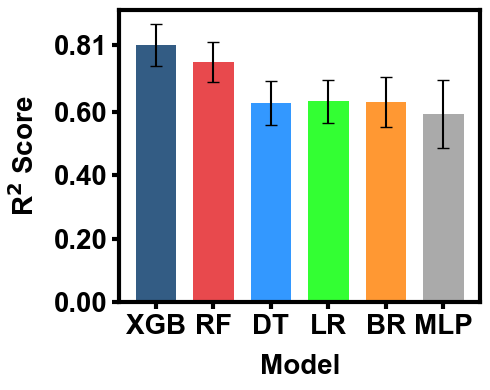

In [37]:
# Create lists for the plot
models = ['XGB', 'RF', 'DT', 'LR', 'BR', 'MLP']
x_pos = np.arange(len(models))

# put the real numbers here

r2_xgb_mean, r2_rf_mean, r2_dt_mean, r2_lr_mean, r2_mlp_mean, r2_br_mean = \
np.mean(r_squareds_global_xgbr), np.mean(r_squareds_global_rfr), np.mean(r_squareds_global_dt),\
np.mean(r_squareds_global_lr), np.mean(r_squareds_global_mlp), np.mean(r_squareds_global_br)  

r2_xgb_std, r2_rf_std, r2_dt_std, r2_lr_std, r2_mlp_std, r2_br_std = \
np.std(r_squareds_global_xgbr), np.std(r_squareds_global_rfr), np.std(r_squareds_global_dt),\
np.std(r_squareds_global_lr), np.std(r_squareds_global_mlp), np.std(r_squareds_global_br)  
# !! should be the same order as models
CTEs = [r2_xgb_mean, r2_rf_mean, r2_dt_mean, r2_lr_mean, r2_br_mean, r2_mlp_mean]
error = [r2_xgb_std, r2_rf_std, r2_dt_std, r2_lr_std, r2_br_std, r2_mlp_std]

# Build the plot
fig, ax = plt.subplots(figsize=(5, 4))
plt.yticks(0.1*np.linspace(0, 8, 5, dtype=int))
ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')


ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.8, width=0.7,
       ecolor='black', 
       color= ('#003366', '#E31B20', '#007FFF', '#00FF00', '#FF7F00', '#959595'),
       capsize=4)

ax.set_ylabel('$r^2$ Score')
plt.xlabel('Model', fontsize='20', fontname='Arial', fontweight='bold', labelpad=10)
plt.ylabel('R$^2$ Score', fontsize='20', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
#ax.set_title(r'$r^2 Score$')
ax.yaxis.grid(True)
[i.set_linewidth(3) for i in ax.spines.values()]
# Save the figure and show
plt.yticks((0.0, 0.20, 0.40, 0.60, 0.81))
plt.tight_layout()
plt.savefig('error_bars_r2.jpeg', dpi=500)

In [38]:
r_squareds_global_xgbr

[[0.8323921664764834],
 [0.8327154486829671],
 [0.6818933875071229],
 [0.8230308712813745],
 [0.8765993189535429]]

In [39]:
r2_xgb_mean

0.8093262385802982

In [40]:
r2_xgb_std

0.06638028022229694

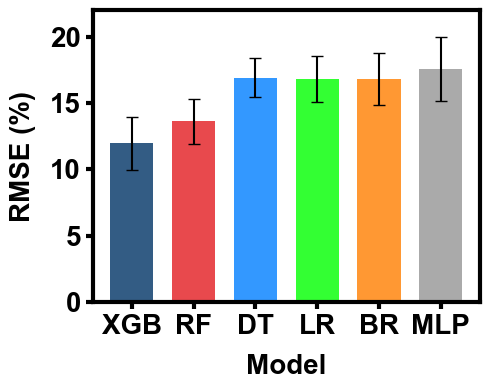

In [41]:
# Create lists for the plot
models = ['XGB', 'RF', 'DT', 'LR', 'BR', 'MLP']
x_pos = np.arange(len(models))

# RMSE mean
RMSE_xgb_mean, RMSE_rf_mean, RMSE_dt_mean, RMSE_br_mean, RMSE_lr_mean, RMSE_mlp_mean= \
np.mean(RMSEs_global_xgbr), np.mean(RMSEs_global_rfr), np.mean(RMSEs_global_dt),\
np.mean(RMSEs_global_br), np.mean(RMSEs_global_lr), np.mean(RMSEs_global_mlp) 
# RMSE std
RMSE_xgb_std, RMSE_rf_std, RMSE_dt_std, RMSE_br_std, RMSE_lr_std, RMSE_mlp_std= \
np.std(RMSEs_global_xgbr), np.std(RMSEs_global_rfr), np.std(RMSEs_global_dt),\
np.std(RMSEs_global_br), np.std(RMSEs_global_lr), np.std(RMSEs_global_mlp) 

## ! should be the same order as models
CTEs = [RMSE_xgb_mean, RMSE_rf_mean, RMSE_dt_mean, RMSE_lr_mean, RMSE_br_mean, RMSE_mlp_mean]
error = [RMSE_xgb_std, RMSE_rf_std, RMSE_dt_std, RMSE_lr_std, RMSE_br_std, RMSE_mlp_std]

# Build the plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')

ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.8, width=0.7,
       ecolor='black', 
       color= ('#003366', '#E31B20', '#007FFF', '#00FF00', '#FF7F00', '#959595'),
       capsize=4)

plt.yticks(np.linspace(0, 20, 5, dtype=int))
ax.set_ylabel('$r^2$ Score')
plt.xlabel('Model', fontsize='20', fontname='Arial', fontweight='bold', labelpad=10)
plt.ylabel('RMSE (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=10)
[i.set_linewidth(3) for i in ax.spines.values()]

ax.set_xticks(x_pos)
ax.set_xticklabels(models)
plt.ylim(0,22)
#ax.set_title(r'$r^2 Score$')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.tight_layout()
plt.savefig('error_bars_RMSE.jpeg', dpi=500)
plt.show()

In [42]:
glob_split

2575

In [43]:
global_split_rand

2571

In [44]:
# XGBoost Regression result
r_squareds_global_xgbr = []
r_squareds_train_global_xgbr = []
importances_global = []
RMSEs_global_xgbr = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
# best split 100, 105
rgboost_rands = np.array (([ 30, 470, 938], [881, 652, 515], 
                           [247, 374, 905], [314, 31, 746], [996, 405, 931]))

#### Materials coef. for 3 time-current properties
#print ('#### material coef. for 3 current properties')
## material coef. Final_Current_Percent
input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                 Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=global_split_rand)

clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_IfImax: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_IfImax: ', pearr[0])

## material coef. I_max normalized
input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                 Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=global_split_rand)
clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_Imax: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_Imax: ', pearr[0])

## material coef.  Norm_charge_tot
input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=global_split_rand)
clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_chargetot: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_chargetot: ', pearr[0])
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

#### proxy XGBoost Final_Current_percent
new_features = np.concatenate ((charge_denisty, pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, df['Material'],
                                     indices, test_size = 0.20, random_state = global_split_rand)
xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                   random_state=30)



xgbr_final_I_percent.fit(train_new_features, train_labels)
Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)  
y_pred = xgbr_final_I_percent.predict(test_new_features)
r_squared_Final_Current_test = r2_score(test_labels, y_pred)
#print('r2 score = ', r_squared_Final_Current_test)
pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
#print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

#### proxy XGBoost Norm_I_Max
new_features = np.concatenate ((charge_denisty,
                                pulsetime, material_type_Norm_I_Max_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = global_split_rand)  
xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                  random_state=470)


xgbr_norm_I_max.fit(train_new_features, train_labels);
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
#print('r2 score for test = ', r_squared_Norm_I_Max_test)
pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
#print('pearson r for test= ', pr_Norm_I_Max_test[0])

#### proxy XGBoost Norm_Norm_charge_tot
#print ('#### proxy XGBoost Norm_Norm_charge_tot')
new_features = np.concatenate ((charge_denisty,pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = global_split_rand)
xgbr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
               learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
              random_state=938)

xgbr_norm_charge_total.fit(train_new_features, train_labels)
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
#print('r2 score for test= ', r_squared_Norm_charge_tot_test)
pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
#print('pearson r for test= ', pr_Norm_charge_tot_test[0])

#### FINAL prediction of Graphene Yield
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']*
                       (resistance_matrix**-1)*df['PulseTime']*(1e-3)).reshape(-1, 1)
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average

mask = np.ones(X_CB_MC_PA_TCB_ps_res_sa_sp2.shape[1], dtype=bool)
mask[[2]] = False
# excluding Surface area
X_CB_MC_PA_TCB_ps_res_sp2 = X_CB_MC_PA_TCB_ps_res_sa_sp2 [..., mask]
df['temp2_norm'] = [math.log(i) for i in df['temp2']]
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                #material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                np.array (df['temp2_norm']).reshape(-1, 1),
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1)
                                                       ), axis=1)
test_size = 0.2
indices = np.arange(len(new_features))
labels = Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state=global_split_rand)
r_squareds = list()
importances = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
r2_max = 0
test_split_seed1 = global_split_rand
test_split_seed2 = global_split_rand + 1
test_split_count = test_split_seed2 - test_split_seed1
rep=10
r_squareds = list()
RMSEs_xgbr = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
# rand = 499 with max of:  0.79
for random_state in range (499, 500):
    # Instantiate model with 1000 decision trees
    xgbr_graphyield = XGBRegressor(max_depth=3, n_estimators=36, 
                                   gamma=0.001, learning_rate=0.099384, 
                                   subsample=0.7746,  min_child_weight=3, 
                                   n_jobs=1, random_state=random_state)

    # Train the model on training data
    xgbr_graphyield.fit(train_new_features, train_labels);
    predictions = xgbr_graphyield.predict(test_new_features)
    r_squared = r2_score(test_labels, predictions)
    r_squareds.append (r_squared)
    train_predictions = xgbr_graphyield.predict(train_new_features)
    r_squared = r2_score(train_labels, train_predictions)
    r_squareds_train.append (r_squared)
    RMSEs_xgbr.append (np.sqrt (mean_squared_error(predictions, test_labels)))
    importance = list(xgbr_graphyield.feature_importances_)
    importances.append (importance)
#m = tf.keras.metrics.RootMeanSquaredError()
pred_test = predictions
#m.update_state(pred_test, test_labels)
#print ('RMSE for test, ', m.result().numpy())
r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
#print ('all r2: ', r_squareds_randomized_testtrain_vec)
r_squareds_global_xgbr.append(r_squareds)
r_squareds_train_global_xgbr.append(r_squareds_train)
RMSEs_global_xgbr.append (RMSEs_xgbr)
list_glob_rand_state.append(global_split_rand)
importances_global.append (importances)
counter += 1
print (RMSEs_global_xgbr)
print (r_squareds_global_xgbr)

[[10.258768986482812]]
[[0.8323921664764834]]


In [45]:
print (np.mean (train_labels))
print (np.mean (test_labels))

54.55430481594204
52.080626342857144


In [46]:
feature_list = ['charge_denisty',
                'material_ps',
                'material_res',
                #'material_sa',
                'material_sp2',
                'PulseTime',
                'Pretreat_voltage',
                'Temp',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']
print (feature_list)
print ('min: ', list (np.round (np.min (new_features, axis=0), 1)))
print ('max: ', list (np.round (np.max (new_features, axis=0), 1)))

['charge_denisty', 'material_ps', 'material_res', 'material_sp2', 'PulseTime', 'Pretreat_voltage', 'Temp', 'Atmosphere_air', 'Atmosphere_arg', 'Final_Current_Percent', 'Norm_I_Max', 'Norm_charge_tot', 'heat_power']
min:  [19.9, 45.0, 0.4, 30.6, 30.0, 0.0, 5.7, 0.0, 0.0, 0.1, 240.5, 8.2, 80.0]
max:  [204.4, 150.0, 7.2, 45.9, 1200.0, 400.0, 10.1, 1.0, 1.0, 0.8, 2289.7, 108.9, 60500.0]


In [47]:
X_CB_MC_PA_TCB_ps_res_sa_sp2

array([[4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [4.50e+01, 2.

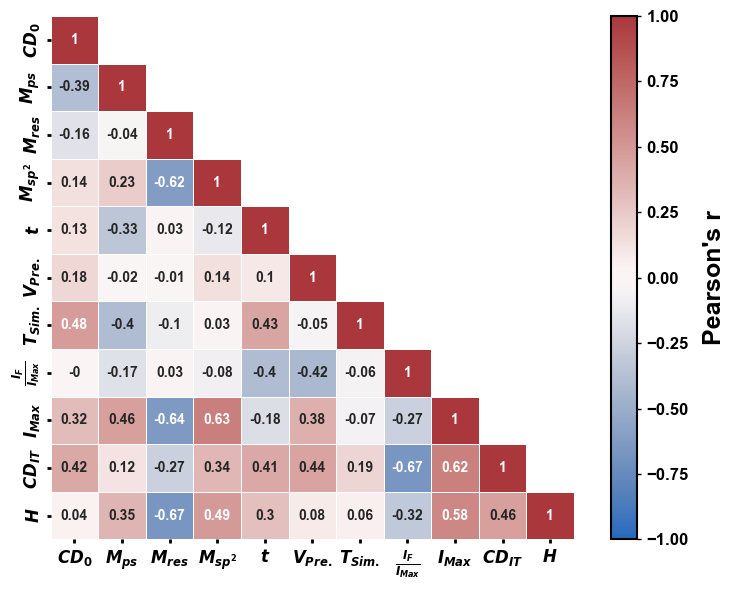

In [48]:
df_corr = pd.DataFrame({})
df_corr ['$CD_0$'] = charge_denisty.ravel()
df_corr ['$M_{ps}$'] = X_CB_MC_PA_TCB_ps_res_sa_sp2[:, 0]
df_corr ['$M_{res}$'] = X_CB_MC_PA_TCB_ps_res_sa_sp2[:, 1]
#df_corr ['$M_{sa}$'] = X_CB_MC_PA_TCB_ps_res_sa_sp2[:, 2]
df_corr ['$M_{sp^2}$'] = X_CB_MC_PA_TCB_ps_res_sa_sp2[:, 3]
df_corr ['$t$'] = pulsetime
df_corr [r'$V_{Pre.}$'] = Pretreat_voltage
df_corr ['$T_{Sim.}$'] = np.array (df['temp2']).reshape(-1, 1)/1000
df_corr [r'$\frac{I_F}{I_{Max}}$'] = Final_Current_Percent_predicted.reshape(-1, 1)
df_corr ['$I_{Max}$'] = Norm_I_Max_predicted.reshape(-1, 1)
df_corr ['$CD_{IT}$'] = Norm_charge_tot_predicted.reshape(-1, 1)
df_corr ['$H$']= heat_power.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(8, 6))                          
matrix = df_corr.corr(
    method = 'pearson',  # The method of correlation
    min_periods = 1      # Min number of observations required
).round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)

cbar_kws = {"shrink": 1, "label":"Pearson's r", }#"labelsize":'12'}

ax2 = sns.heatmap(matrix, 
                 annot=True, cbar=True,
                 vmax=1, vmin=-1, center=0, cmap='vlag', linewidth=0.5, square=True,
                 mask=mask, cbar_kws=cbar_kws)

ax.figure.axes[-1].set_ylabel("Pearson's r", size=18, fontname='Arial', 
                              fontweight='bold', labelpad=10)
ax.figure.axes[-1].tick_params(direction='out', length=3, width=1, colors='black', grid_alpha=0, labelsize='12')
[i.set_linewidth(1.5) for i in ax.figure.axes[-1].spines.values()]
"""
cb = fig.colorbar(p, ax=ax)
cb.set_label('Charge Density (C/g)', fontsize='20', fontname='Arial', 
             fontweight='bold', labelpad=10)
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(axis='both', which='major', labelsize=20, width=2)
[i.set_linewidth(1.5) for i in cb.ax.spines.values()]

"""
ax.set(xlabel="", ylabel="")
ax.tick_params(axis='x', direction='out', length=3, width=2, colors='black', grid_alpha=0, labelsize='12')
ax.tick_params(axis='y', direction='out', length=3, width=2, colors='black', grid_alpha=0, labelsize='12')
plt.tight_layout()
plt.savefig('corr_map.jpeg', dpi=500)

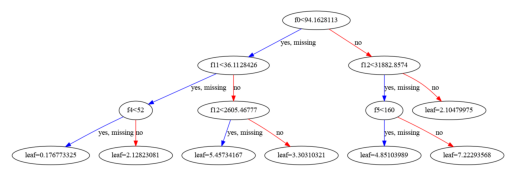

In [49]:
feature_list = ['charge_denisty',
                'material_ps',
                'material_res',
                #'material_sa',
                'material_sp2',
                'PulseTime',
                'Pretreat_voltage',
                'Temp',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']
for i in range(1, 2):
    plot_tree(xgbr_graphyield, num_trees=i, # fontsize=20,
              feature_names=feature_list)#filled=True)#rankdir='LR',)

    plt.savefig('tree_plot{}.jpeg'.format(i), dpi=2000)

In [50]:
feature_list = ['charge_denisty',
                'material_ps',
                'material_res',
                #'material_sa',
                'material_sp2',
                #'material_CB',
                #'material_MC',
                #'material_PA',
                #'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                'Temp',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']

importances = list(xgbr_graphyield.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

Variable: charge_denisty Importance: ('charge_denisty', 0.24)
Variable: material_ps Importance: ('material_ps', 0.1)
Variable: material_res Importance: ('material_res', 0.04)
Variable: material_sp2 Importance: ('material_sp2', 0.03)
Variable: PulseTime Importance: ('PulseTime', 0.02)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.04)
Variable: Temp Importance: ('Temp', 0.18)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.04)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.04)
Variable: Final_Current_Percent Importance: ('Final_Current_Percent', 0.07)
Variable: Norm_I_Max Importance: ('Norm_I_Max', 0.04)
Variable: Norm_charge_tot Importance: ('Norm_charge_tot', 0.09)
Variable: heat_power Importance: ('heat_power', 0.07)


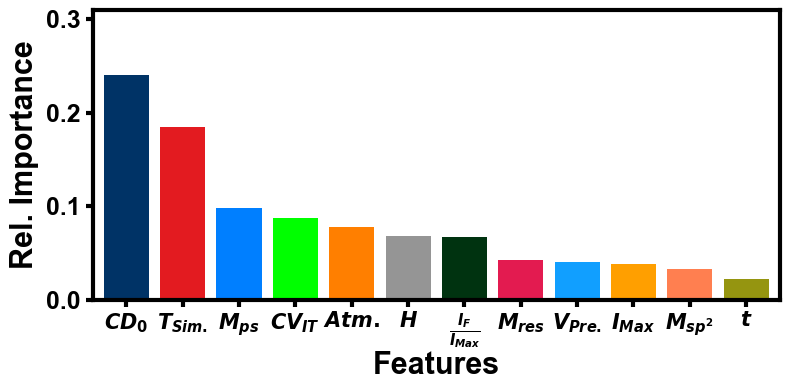

In [51]:
# Create lists for the plot
# including the error bar
feature_list_abbrev0 = ['$CD_0$',
                '$M_{ps}$',
                '$M_{res}$',
                #'$M_{sa}$',
                '$M_{sp^2}$',
                #'material_CB',
                #'material_MC',
                #'material_PA',
                #'material_TCB',
                '$t$',
                r'$V_{Pre.}$',
                '$T_{Sim.}$',
                'Atmtype',
                'Atmtype2',
                r'$\frac{I_F}{I_{Max}}$',
                '$I_{Max}$',
                '$CV_{IT}$',
                '$H$']
importances_global = np.array (importances_global).ravel()
feature_list_abbrev = np.tile ((feature_list_abbrev0), 5)

data_importance = pd.DataFrame({})
data_importance ['importance'] = importances_global
data_importance ['feature'] = feature_list_abbrev0

# combine air and arg together, remove M_SA with 0 importance
air_importance = np.array (data_importance['importance'].loc[data_importance['feature']=='Atmtype'])
arg_importance = np.array (data_importance['importance'].loc[data_importance['feature']=='Atmtype2'])
data_importance_atmcomb = data_importance.copy()

air_importance = np.array (data_importance['importance'].loc[data_importance['feature']=='Atmtype'])
arg_importance = np.array (data_importance['importance'].loc[data_importance['feature']=='Atmtype2'])
atm_importance = np.add (air_importance, arg_importance)
for i in atm_importance:
    data_importance_atmcomb.loc[len(data_importance_atmcomb.index)] = [i, '$Atm.$']
    
data_importance_atmcomb = data_importance_atmcomb[data_importance_atmcomb.feature != 'Atmtype']
data_importance_atmcomb = data_importance_atmcomb[data_importance_atmcomb.feature != 'Atmtype2']
data_importance_atmcomb = data_importance_atmcomb[data_importance_atmcomb.feature != '$M_{sa}$']

imp_mean = data_importance_atmcomb.groupby('feature').mean()
imp_std = data_importance_atmcomb.groupby('feature').std()


imp_std = imp_std.rename(columns={"importance": "sd"})
imp_mean_sorted = imp_mean.sort_values (by=['importance'], ascending=False)
imp_data_mean_sd = pd.merge (imp_mean_sorted, imp_std, on='feature')


features = imp_data_mean_sd.index
#features = imp_data_mean_sd['feature']
x_pos = np.arange(len(features))

# !! should be the same order as features
features 
CTEs = list (imp_data_mean_sd['importance'].ravel())
error = list (imp_data_mean_sd['sd'].ravel())

# Build the plot
fig, ax = plt.subplots(figsize=(8, 4))
plt.yticks(0.1*np.linspace(0, 8, 5, dtype=int))
ax.tick_params(axis='x', direction='out', length=5, width=3, 
               colors='black', grid_alpha=0, labelsize='15')
ax.tick_params(axis='y', direction='out', length=5, width=3, 
               colors='black', grid_alpha=0, labelsize='18')


ax.bar(x_pos, CTEs, #yerr=error, 
       align='center', 
       alpha=1, width=0.8,
       ecolor='black', 
       color= ('#003366', '#E31B20', '#007FFF', '#00FF00', '#FF7F00', '#959595', 
              '#003310', '#E31B50', '#119FFF', '#FF9F00', '#FF7F50', '#959510'),
       capsize=3)

ax.set_ylabel('$r^2$ Score')
#plt.xticks([i*2 for i in range(6)], labels)

plt.xlabel('Features', fontsize='22', fontname='Arial', fontweight='bold', labelpad=0)
plt.ylabel('Rel. Importance', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(features)
#ax.set_title(r'$r^2 Score$')
ax.yaxis.grid(True)
[i.set_linewidth(3) for i in ax.spines.values()]
# Save the figure and show
plt.yticks((0.0, 0.1, 0.2, 0.3,))
plt.ylim(0, 0.31)
plt.xlim(-0.6, 11.6)
plt.tight_layout()
#
plt.savefig('importance_plt.jpeg', dpi=500)

(51.42857142857142, 17.142857142857142, 20.0, 5.714285714285714, 5.714285714285714)


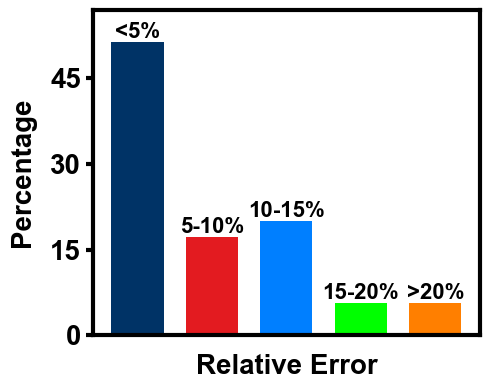

In [52]:
# make the numbers on axis bold
from matplotlib import rc, rcParams
error_group = ['<5%', '5-10%', '10-15%', '15-20%', '>20%']

abs_err = np.abs(pred_test.reshape(-1, 1)-test_labels.reshape(-1, 1))
less_5 = abs_err [abs_err <= 5]
larger_5 = abs_err [abs_err > 5]
larger_5_less_10 = larger_5 [larger_5 <= 10]
larger_10 = abs_err [abs_err > 10]
larger_10_less_15 = larger_10 [larger_10 <= 15]

larger_15 = abs_err [abs_err > 15]
larger_15_less_20 = larger_15 [larger_15 <= 20]
larger_20 = abs_err [abs_err > 20]
n_test = pred_test.shape[0]


#rc('font', weight='bold')
plt.close()
plt.figure(figsize = (5, 4))
frequencies = [less_5.shape[0]/n_test*100, larger_5_less_10.shape[0]/n_test*100, 
               larger_10_less_15.shape[0]/n_test*100, larger_15_less_20.shape[0]/n_test*100, 
               larger_20.shape[0]/n_test*100]

print ( ((less_5.shape[0]/n_test*100, larger_5_less_10.shape[0]/n_test*100, 
               larger_10_less_15.shape[0]/n_test*100, larger_15_less_20.shape[0]/n_test*100, 
               larger_20.shape[0]/n_test*100)))
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', width=0.7,
                      color = ['#003366', '#E31B20', '#007FFF', '#00FF00', '#FF7F00', '#959595'])

rects = ax.patches
x_labels = [ ]
labels = ['<5%', '5-10%', '10-15%', '15-20%', '>20%']

ax.tick_params(axis='x', direction='out', length=0, width=3, 
               colors='black', grid_alpha=0, labelsize='20')
ax.tick_params(axis='y', direction='out', length=5, width=3, 
               colors='black', grid_alpha=0, labelsize='20')

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, fontsize = 16, fontweight='bold',
            ha='center', va='bottom')
ax.set_xticklabels(x_labels)
plt.ylim(0, 57)
[i.set_linewidth(3) for i in ax.spines.values()]
plt.yticks([0, 15,  30, 45], fontsize = 20)
plt.ylabel("Percentage", fontsize=20, fontweight='bold', fontname='Arial', labelpad=10)
plt.xlabel("Relative Error", fontsize=20, fontweight='bold', fontname='Arial', labelpad=10)
plt.tight_layout()
plt.savefig('err_dist.jpeg', dpi=500, bbox_inches='tight')

In [53]:
pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = (pred_test.reshape(-1, 1) - test_labels)
errors_abs_test = abs(pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['abs_errors'] = errors_abs_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels

In [54]:
np.array (df['Graphene_Yield']).ravel().shape

(173,)

In [55]:
pred_train = xgbr_graphyield.predict(new_features)
errors_train = (pred_train.reshape(-1, 1) - np.array (df['Graphene_Yield']).reshape (-1, 1))
errors_abs_train = abs(pred_train.reshape(-1, 1) - np.array (df['Graphene_Yield']).reshape (-1, 1))
id_errors = list(range(errors_train.shape[0]))
#plt.plot(id_errors, errors_train, c=id_train)

df['id_errors'] = id_errors
df['errors'] = errors_train
df['abs_errors'] = errors_abs_train
df['Graphene_Yield_per'] = df['Graphene_Yield']
df['y_pred'] = pred_train
df['y_true'] = np.array (df['Graphene_Yield']).reshape (-1, 1)

Correlation between error and GY PearsonRResult(statistic=-0.6362273703059964, pvalue=3.991883228035023e-05)


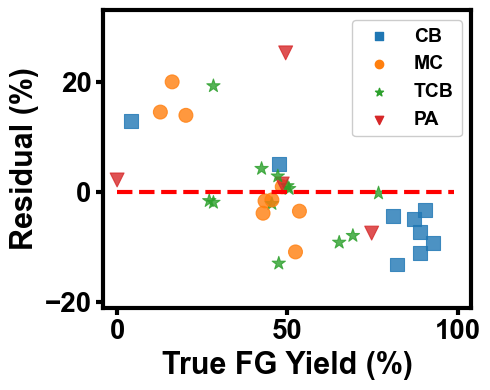

In [56]:
print ('Correlation between error and GY', 
       pearsonr(df_test['errors'].ravel(), df_test['y_true'].ravel()))
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
markers = ['v',  's', 'o', '*']
sns.scatterplot(data=df_test, x='y_true', y='errors',
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.8, s=100)

plt.legend(fontsize=14, framealpha=1)
plt.xticks((0, 50, 100))
x = list(range(0, 100))
y = np.repeat(0, 100)
plt.xlim (-4, 104)

plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (%)', fontsize='22', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.ylim(-21, 33)
plt.yticks((-20, 0, 20))

plt.tight_layout()
plt.savefig('resVSGY_test.jpeg', dpi=500)

Correlation between error and GY PearsonRResult(statistic=-0.6362273703059964, pvalue=3.991883228035023e-05)


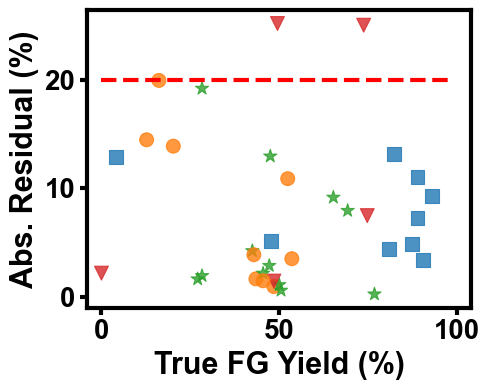

In [57]:
print ('Correlation between error and GY', 
       pearsonr(df_test['errors'].ravel(), df_test['y_true'].ravel()))
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
markers = ['v',  's', 'o', '*']
sns.scatterplot(data=df_test, x='y_true', y='abs_errors',
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.8, s=100)

#plt.legend(fontsize=12, framealpha=0.5, loc='upper right')
plt.xticks((0, 50, 100))
x = list(range(0, 100))
y = np.repeat(20, 100)
plt.xlim (-4, 104)
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Residual (%)', fontsize='22', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('absresVSGY_test.jpeg', dpi=500)

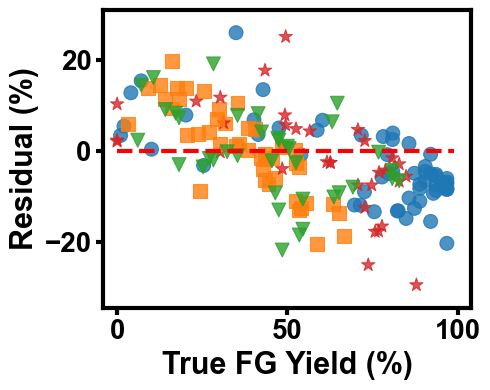

In [58]:
# Plot
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = (predictions.reshape(-1, 1) - labels)
df['errors'] = errors_all
df['abs_errors'] = abs(errors_all)
df['Graphene_Yield_per'] = df['Graphene_Yield']

fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
markers = ['o', 's', '*', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']

sns.scatterplot(data=df, x='Graphene_Yield', y='errors',
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.8, s=100)

plt.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xlabel('True FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (%)', fontsize='22', fontname='Arial', fontweight='bold')
plt.xlim (-4, 104)
plt.ylim (min(df ['errors'])-5, max(df ['errors'])+5)
x2 = list(range(0, 100))
y2 = np.repeat(0, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('resVSGY.jpeg', dpi=500)

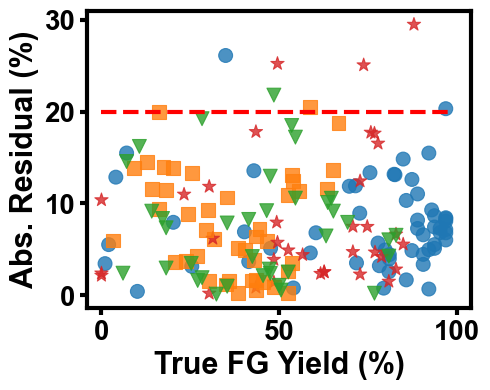

In [59]:
# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '*', 'v']
colors=['blue', 'red', 'green', 'orange']
sns.scatterplot(data=df, x='Graphene_Yield_per', y='abs_errors',
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.8, s=100)

#plt.legend(fontsize=12, framealpha=0.5, loc='upper right')
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xlabel('True FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Residual (%)', fontsize='22', fontname='Arial', fontweight='bold')
plt.xlim (-4, 104)
x2 = list(range(0, 100))
y2 = np.repeat(20, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('abs_resVSGY.jpeg', dpi=500)

r2 value:  0.8323921664764834


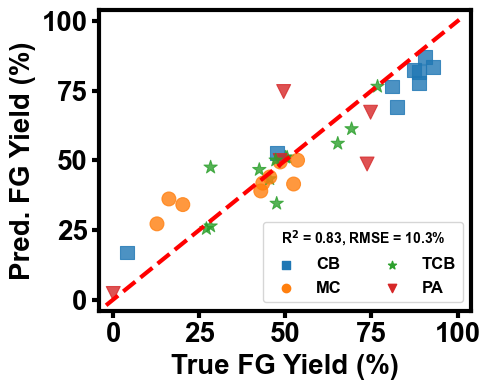

In [60]:
groups = df_test.groupby(['Material'])
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['v', 's', 'o', '*']
colors=['blue', 'red', 'green', 'orange']
sns.scatterplot(data=df_test, x='y_true', y='y_pred', 
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.8, s=100)

#plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_xlabel('True FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)

r2 = r2_score (df_test['y_true'], df_test['y_pred']) 
ax.plot(x2, y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

rmse = np.sqrt (mean_squared_error(df_test['y_pred'], df_test['y_true']))

ax.legend(title='R$^2$ = {}, RMSE = {}%'.format(round(r2, 2), round (rmse, 1)), 
          frameon=True, ncol=2, fontsize=12,)
plt.xlim (-4, 104)
plt.ylim (-4, 104)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))
# Save
print ('r2 value: ', r2_score (df_test['y_true'], df_test['y_pred']))
plt.tight_layout()
plt.savefig('XGBPerformance_matg.jpeg', dpi=500)

In [61]:
# normalize the temperature
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
# get the log10 of the temperature results.
df_test['temp2_norm'] = [math.log(i) for i in df_test['temp2']]
#math.log10(np.array (df_test['temp2']))
df['temp2_norm'] = [math.log(i) for i in df['temp2']]
#math.log10(np.array (df_test['temp2']))

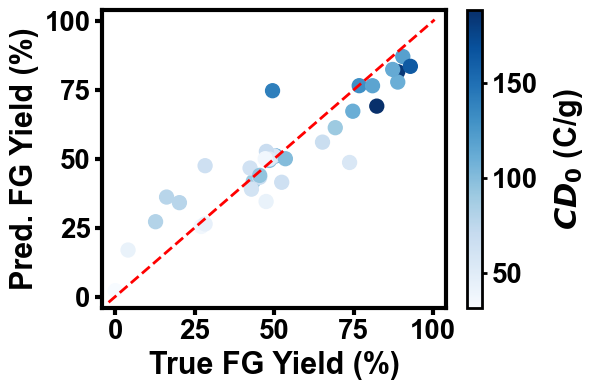

In [62]:
# !!! try also regular coloring not by groups
# Plot pred vs. true values for test set, coloring the charge density
groups = df_test.groupby(['Material'])
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=0, labelsize='20')

"""
for name, group in groups:
    p = ax.scatter(group.y_true, group.y_pred,  c=group.charge_density, marker='o', s=100, cmap='Reds')
"""
p = plt.scatter (df_test['y_true'], 
             df_test['y_pred'], 
             c=df_test['charge_density'], s=100,
            cmap='Blues')
#plt.colorbar()
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('$CD_0$ (C/g)', fontsize='22', fontname='Arial', 
             fontweight='bold', labelpad=10)
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(axis='both', which='major', labelsize=20, width=2)
[i.set_linewidth(2) for i in cb.ax.spines.values()]

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('True FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))
plt.xlim (-4, 104)
plt.ylim (-4, 104)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='red')
# ax.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]


plt.tight_layout()
plt.savefig('XGBR_colorCD2.jpeg', dpi=500)

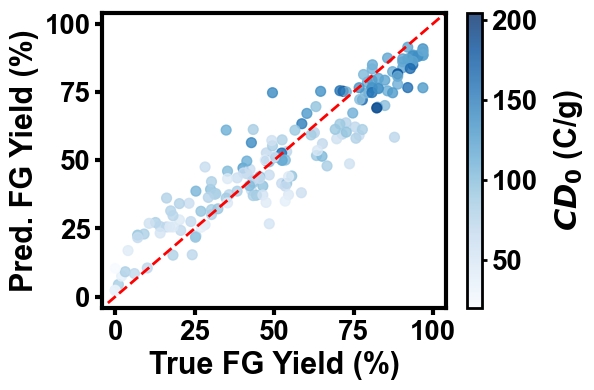

In [63]:
# !!! try also regular coloring not by groups
# Plot pred vs. true values for test set, coloring the charge density
groups = df.groupby(['Material'])
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=0, labelsize='20')

"""
for name, group in groups:
    p = ax.scatter(group.y_true, group.y_pred,  c=group.charge_density, marker='o', s=100, cmap='Reds')
"""
p = plt.scatter (df['y_true'], 
             df['y_pred'], 
             c=df['charge_density'], s=50, alpha=0.8, 
            cmap='Blues')

#plt.colorbar()
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('$CD_0$ (C/g)', fontsize='22', fontname='Arial', 
             fontweight='bold', labelpad=10)
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(axis='both', which='major', labelsize=20, width=2)
[i.set_linewidth(2) for i in cb.ax.spines.values()]

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('True FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))
plt.xlim (-4, 104)
plt.ylim (-4, 104)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='red')
# ax.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]


plt.tight_layout()
plt.savefig('XGBR_colorCD_alldata.jpeg', dpi=500)

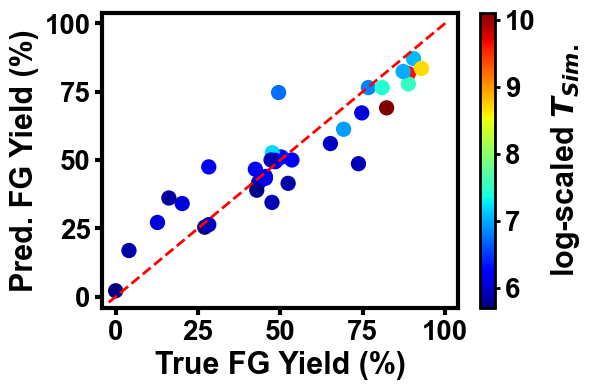

In [64]:
# !!! try also regular coloring not by groups
# Plot pred vs. true values for test set, coloring the charge density
groups = df_test.groupby(['Material'])
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, 
               labelsize='20')

"""
for name, group in groups:
    p = ax.scatter(group.y_true, group.y_pred,  c=group.charge_density, 
    marker='o', s=100, cmap='Reds')
"""
p = plt.scatter (df_test['y_true'], 
             df_test['y_pred'], s=100,
             c=df_test['temp2_norm'], 
             cmap='jet')
#plt.colorbar()
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('log-scaled $T_{Sim.}$', fontsize='22', fontname='Arial', 
             fontweight='bold', labelpad=10)
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(axis='both', which='major', labelsize=20, width=2)
[i.set_linewidth(2) for i in cb.ax.spines.values()]

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('True FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))
plt.xlim (-4, 104)
plt.ylim (-4, 104)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='red')
# ax.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]


plt.tight_layout()
plt.savefig('XGBR_colortemp.jpeg', dpi=500)
plt.show()

In [65]:
df_test['temp2_norm']

89      6.063684
49     10.106952
43      5.866397
125     6.054034
146     6.660370
170     6.228016
164     6.935869
103     6.721847
62      5.855672
128     6.071794
54      7.181658
150     6.178198
90      5.701366
37      9.625487
123     6.003472
72      6.055892
172     5.716316
158     6.835617
81      6.148251
145     6.180488
151     5.914049
23      7.056605
41      7.437018
141     6.211911
101     5.918613
171     5.895533
51      8.693914
76      6.206964
140     5.936613
163     5.966979
126     6.130241
124     5.815640
25      7.513796
63      5.764089
5       7.000331
Name: temp2_norm, dtype: float64

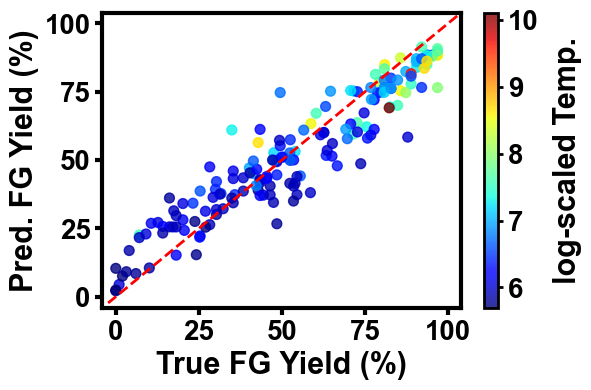

In [66]:
# !!! try also regular coloring not by groups
# Plot pred vs. true values for test set, coloring the charge density
groups = df.groupby(['Material'])
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, 
               labelsize='20')

"""
for name, group in groups:
    p = ax.scatter(group.y_true, group.y_pred,  c=group.charge_density, 
    marker='o', s=100, cmap='Reds')
"""
p = plt.scatter (df['y_true'].loc[df['temp2']>0], 
             df['y_pred'].loc[df['temp2']>0], s=50,
             c=df['temp2_norm'].loc[df['temp2']>0], alpha=0.8,
             cmap='jet')
#plt.colorbar()
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('log-scaled Temp.', fontsize='22', fontname='Arial', 
             fontweight='bold', labelpad=10)
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(axis='both', which='major', labelsize=20, width=2)
[i.set_linewidth(2) for i in cb.ax.spines.values()]

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('True FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. FG Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))
plt.xlim (-4, 104)
plt.ylim (-4, 104)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='red')
# ax.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]


plt.tight_layout()
plt.savefig('XGBR_colortemp_alldata.jpeg', dpi=500)

proxy XGBoost Final_Current_percent
Pearson r for test samples=  0.8103699728820322
proxy XGBoost Norm_I_Max
pearson r for test=  0.7955770249850228
proxy XGBoost Norm_Norm_charge_tot
pearson r for test=  0.7742084388041762


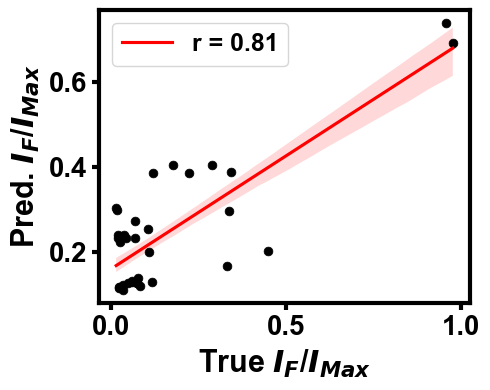

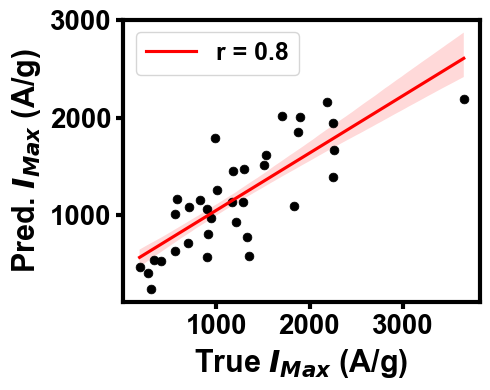

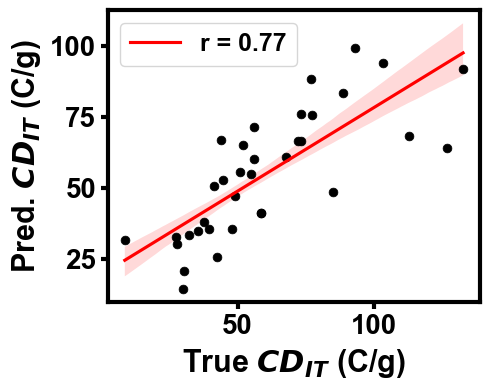

In [67]:
# XGBoost Regression result for the global split
r_squareds_global_xgbr = []
RMSEs_global_xgbr = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()

#### Materials coef. for 3 time-current properties
#print ('#### material coef. for 3 current properties')
## material coef. Final_Current_Percent
input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                 Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=7)

clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_IfImax: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_IfImax: ', pearr[0])

## material coef. I_max normalized
input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                 Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=7)
clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_Imax: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_Imax: ', pearr[0])

## material coef.  Norm_charge_tot
input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=7)
clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_chargetot: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_chargetot: ', pearr[0])
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

#### proxy XGBoost Final_Current_percent
print ('proxy XGBoost Final_Current_percent')
new_features = np.concatenate ((charge_denisty, pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, df['Material'],
                                     indices, test_size = 0.20, random_state = glob_split)
xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                   random_state=7)

xgbr_final_I_percent.fit(train_new_features, train_labels)
Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)  
y_pred = xgbr_final_I_percent.predict(test_new_features)
r_squared_Final_Current_test = r2_score(test_labels, y_pred)
#print('r2 score = ', r_squared_Final_Current_test)
pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = y_pred
data['y_true'] = test_labels
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_pred'] > 0]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns1 = sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred',
            scatter_kws={"color": "black"}, line_kws={"color": "red"},
            ci=70, order=1, label='r = {}'.format(round(pearsonr_Final_Current_test[0], 2)), scatter=False)

sns.scatterplot(data=data_outlier_removed, x='y_true', y='y_pred',
                      edgecolor=None, s=40, color='black')
sns1.legend(loc='upper left', fontsize=18)

ax.set_ylabel('Pred. $I_{F}$/$I_{Max}$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True $I_{F}$/$I_{Max}$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(3) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
#plt.yticks((0.1, 0.3, 0.5))
#plt.xticks((0.1, 0.5, 0.9))

"""
plt.title("Pearson's r = {}".format(round(pearsonr_Final_Current_test[0], 2)), 
          loc='left', fontname='Arial', fontsize=22, pad=10,
          fontweight='bold', color='darkred')
"""
plt.tight_layout()
plt.savefig('pred_IfinalImax.jpeg', dpi=500)

#### proxy XGBoost Norm_I_Max
print ('proxy XGBoost Norm_I_Max')
new_features = np.concatenate ((charge_denisty,
                                pulsetime, material_type_Norm_I_Max_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state=7)  
xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                  random_state=7)

xgbr_norm_I_max.fit(train_new_features, train_labels);
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
#print('r2 score for test = ', r_squared_Norm_I_Max_test)
pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
print('pearson r for test= ', pr_Norm_I_Max_test[0])
# plot pred. vs. true value
fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Norm_I_Max_test
data['y_true'] = test_labels 
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_true'] > 0]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)

sns1 = sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred',
            scatter_kws={"color": "black"}, line_kws={"color": "red"},
            ci=70, order=1, label='r = {}'.format(round(pr_Norm_I_Max_test[0], 2)), scatter=False)

sns.scatterplot(data=data_outlier_removed, x='y_true', y='y_pred',
                      edgecolor=None, s=40, color='black')
sns1.legend(loc='upper left', fontsize=18)

ax.set_ylabel('Pred. $I_{Max}$ (A/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True $I_{Max}$ (A/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(3) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
#plt.xticks((500, 1000, 1500, 2000))
#plt.yticks((500, 1000, 1500, 2000))
"""
plt.title("Pearson's r = {}".format(round(pr_Norm_I_Max_test[0], 2)), 
          loc='left', fontname='Arial', fontsize=22, pad=10,
          fontweight='bold', color='darkred')
"""

plt.tight_layout()
plt.savefig('pred_norm_Imax.jpeg', dpi=500)

#### proxy XGBoost Norm_charge_tot
print ('proxy XGBoost Norm_Norm_charge_tot')
#print ('#### proxy XGBoost Norm_Norm_charge_tot')
new_features = np.concatenate ((charge_denisty,pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state=7)
xgbr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
               learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
              random_state=7)

xgbr_norm_charge_total.fit(train_new_features, train_labels)
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
#print('r2 score for test= ', r_squared_Norm_charge_tot_test)
pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
print('pearson r for test= ', pr_Norm_charge_tot_test[0])

fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Norm_charge_tot_test
data['y_true'] = test_labels 
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_true'] > 0]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
sns1 = sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred',
            scatter_kws={"color": "black"}, line_kws={"color": "red"},
            ci=70, order=1, label='r = {}'.format(round(pr_Norm_charge_tot_test[0], 2)), scatter=False)

sns.scatterplot(data=data_outlier_removed, x='y_true', y='y_pred',
                      edgecolor=None, s=40, color='black')
sns1.legend(loc='upper left', fontsize=18)

#plt.legend(['r = {}'.format(round(pr_Norm_charge_tot_test[0], 2))], frameon=True, loc='upper left')
ax.set_ylabel('Pred. $CD_{IT}$ (C/g)', fontsize='22', fontname='Arial', 
              fontweight='bold', labelpad=5)
ax.set_xlabel('True $CD_{IT}$ (C/g)', fontsize='22', fontname='Arial', 
              fontweight='bold', labelpad=5)
[i.set_linewidth(3) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, 
               grid_alpha=0, labelsize='20')
"""
plt.title("Pearson's r = {}".format(round(pr_Norm_charge_tot_test[0], 2)), 
          loc='left', fontname='Arial', fontsize=22, pad=10,
          fontweight='bold', color='darkred')
"""
#plt.legend(['r = {}'.format(round(pearr[0], 2))], frameon=True, loc='upper left', fontsize=15, )#labelcolor='red')
#plt.xticks((20, 70, 120))
#plt.yticks((20, 70, 120))
#plt.legend(['r = {}'.format(round(pr_Norm_charge_tot_test[0], 2))], frameon=True, loc='upper left')

plt.tight_layout()
plt.savefig('pred_norm_total_charge.jpeg', dpi=500)

In [68]:
# XGBoost Regression result
# !!!!!!!!!! exclude the temperature
r_squareds_global_xgbr = []
r_squareds_train_global_xgbr = []
importances_global = []
RMSEs_global_xgbr = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
# best split 100, 105
rgboost_rands = np.array (([ 30, 470, 938], [881, 652, 515], 
                           [247, 374, 905], [314, 31, 746], [996, 405, 931]))

#### Materials coef. for 3 time-current properties
#print ('#### material coef. for 3 current properties')
## material coef. Final_Current_Percent
input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                 Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=global_split_rand)

clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_IfImax: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_IfImax: ', pearr[0])

## material coef. I_max normalized
input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                 Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=global_split_rand)
clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_Imax: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_Imax: ', pearr[0])

## material coef.  Norm_charge_tot
input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=global_split_rand)
clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_chargetot: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_chargetot: ', pearr[0])
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

#### proxy XGBoost Final_Current_percent
new_features = np.concatenate ((charge_denisty, pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, df['Material'],
                                     indices, test_size = 0.20, random_state = global_split_rand)
xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                   random_state=30)



xgbr_final_I_percent.fit(train_new_features, train_labels)
Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)  
y_pred = xgbr_final_I_percent.predict(test_new_features)
r_squared_Final_Current_test = r2_score(test_labels, y_pred)
#print('r2 score = ', r_squared_Final_Current_test)
pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
#print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

#### proxy XGBoost Norm_I_Max
new_features = np.concatenate ((charge_denisty,
                                pulsetime, material_type_Norm_I_Max_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = global_split_rand)  
xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                  random_state=470)


xgbr_norm_I_max.fit(train_new_features, train_labels);
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
#print('r2 score for test = ', r_squared_Norm_I_Max_test)
pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
#print('pearson r for test= ', pr_Norm_I_Max_test[0])

#### proxy XGBoost Norm_Norm_charge_tot
#print ('#### proxy XGBoost Norm_Norm_charge_tot')
new_features = np.concatenate ((charge_denisty,pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = global_split_rand)
xgbr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
               learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
              random_state=938)

xgbr_norm_charge_total.fit(train_new_features, train_labels)
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
#print('r2 score for test= ', r_squared_Norm_charge_tot_test)
pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
#print('pearson r for test= ', pr_Norm_charge_tot_test[0])

#### FINAL prediction of Graphene Yield
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']*
                       (resistance_matrix**-1)*df['PulseTime']*(1e-3)).reshape(-1, 1)
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average

mask = np.ones(X_CB_MC_PA_TCB_ps_res_sa_sp2.shape[1], dtype=bool)
mask[[2]] = False
# excluding Surface area
X_CB_MC_PA_TCB_ps_res_sp2 = X_CB_MC_PA_TCB_ps_res_sa_sp2 [..., mask]
df['temp2_norm'] = [math.log(i) for i in df['temp2']]
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                #material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                #np.array (df['temp2_norm']).reshape(-1, 1),
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1)
                                                       ), axis=1)
test_size = 0.2
indices = np.arange(len(new_features))
labels = Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state=global_split_rand)
r_squareds = list()
importances = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
r2_max = 0
test_split_seed1 = global_split_rand
test_split_seed2 = global_split_rand + 1
test_split_count = test_split_seed2 - test_split_seed1
rep=10
r_squareds = list()
RMSEs_xgbr = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
# rand = 499 with max of:  0.79
for random_state in range (499, 500):
    # Instantiate model with 1000 decision trees
    xgbr_graphyield = XGBRegressor(max_depth=3, n_estimators=36, 
                                   gamma=0.001, learning_rate=0.099384, 
                                   subsample=0.7746,  min_child_weight=3, 
                                   n_jobs=1, random_state=random_state)

    # Train the model on training data
    xgbr_graphyield.fit(train_new_features, train_labels);
    predictions = xgbr_graphyield.predict(test_new_features)
    r_squared = r2_score(test_labels, predictions)
    r_squareds.append (r_squared)
    train_predictions = xgbr_graphyield.predict(train_new_features)
    r_squared = r2_score(train_labels, train_predictions)
    r_squareds_train.append (r_squared)
    RMSEs_xgbr.append (np.sqrt (mean_squared_error(predictions, test_labels)))
    importance = list(xgbr_graphyield.feature_importances_)
    importances.append (importance)
#m = tf.keras.metrics.RootMeanSquaredError()
pred_test = predictions
#m.update_state(pred_test, test_labels)
#print ('RMSE for test, ', m.result().numpy())
r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
#print ('all r2: ', r_squareds_randomized_testtrain_vec)
r_squareds_global_xgbr.append(r_squareds)
r_squareds_train_global_xgbr.append(r_squareds_train)
RMSEs_global_xgbr.append (RMSEs_xgbr)
list_glob_rand_state.append(global_split_rand)
importances_global.append (importances)
counter += 1
print (RMSEs_global_xgbr)
print (r_squareds_global_xgbr)

[[11.373506525822183]]
[[0.793987973431865]]


r2 value:  0.793987973431865


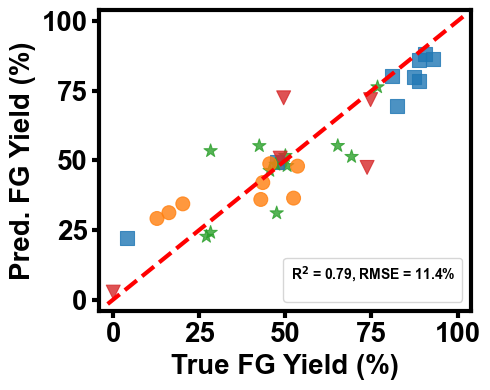

In [69]:
df_test['y_pred'] = pred_test
groups = df_test.groupby(['Material'])
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['v', 's', 'o', '*']
colors=['blue', 'red', 'green', 'orange']
sns.scatterplot(data=df_test, x='y_true', y='y_pred', 
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.8, s=100)

#plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_xlabel('True FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)

r2 = r2_score (df_test['y_true'], df_test['y_pred']) 
ax.plot(x2, y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

rmse = np.sqrt (mean_squared_error(df_test['y_pred'], df_test['y_true']))

ax.legend( [], title='R$^2$ = {}, RMSE = {}%'.format(round(r2, 2), round (rmse, 1)),  
           frameon=True, ncol=2, fontsize=13, loc='lower right')
plt.xlim (-4, 104)
plt.ylim (-4, 104)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))
# Save
print ('r2 value: ', r2_score (df_test['y_true'], df_test['y_pred']))
plt.tight_layout()
plt.savefig('XGBPerformance_notemp.jpeg', dpi=500)

In [70]:
# XGBoost Regression result
# !!!!!!!!!! exclude the temperature and Current-derived properties
r_squareds_global_xgbr = []
r_squareds_train_global_xgbr = []
importances_global = []
RMSEs_global_xgbr = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
counter = 0
# best split 100, 105
rgboost_rands = np.array (([ 30, 470, 938], [881, 652, 515], 
                           [247, 374, 905], [314, 31, 746], [996, 405, 931]))

#### Materials coef. for 3 time-current properties
#print ('#### material coef. for 3 current properties')
## material coef. Final_Current_Percent
input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                 Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=global_split_rand)

clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_IfImax: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_IfImax: ', pearr[0])

## material coef. I_max normalized
input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                 Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=global_split_rand)
clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_Imax: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_Imax: ', pearr[0])

## material coef.  Norm_charge_tot
input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=global_split_rand)
clf = linear_model.LinearRegression()
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
y_pred = clf.predict (X_test)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
#print ('r2 mat_chargetot: ', r2)
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
#print ('pearson r mat_chargetot: ', pearr[0])
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

#### proxy XGBoost Final_Current_percent
new_features = np.concatenate ((charge_denisty, pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, df['Material'],
                                     indices, test_size = 0.20, random_state = global_split_rand)
xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                   random_state=30)



xgbr_final_I_percent.fit(train_new_features, train_labels)
Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)  
y_pred = xgbr_final_I_percent.predict(test_new_features)
r_squared_Final_Current_test = r2_score(test_labels, y_pred)
#print('r2 score = ', r_squared_Final_Current_test)
pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
#print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

#### proxy XGBoost Norm_I_Max
new_features = np.concatenate ((charge_denisty,
                                pulsetime, material_type_Norm_I_Max_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = global_split_rand)  
xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                  random_state=470)


xgbr_norm_I_max.fit(train_new_features, train_labels);
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
#print('r2 score for test = ', r_squared_Norm_I_Max_test)
pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
#print('pearson r for test= ', pr_Norm_I_Max_test[0])

#### proxy XGBoost Norm_Norm_charge_tot
#print ('#### proxy XGBoost Norm_Norm_charge_tot')
new_features = np.concatenate ((charge_denisty,pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type, Pretreat_voltage), axis=1)
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = global_split_rand)
xgbr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
               learning_rate=0.0994, subsample=0.75, min_child_weight=3, n_jobs=1,
              random_state=938)

xgbr_norm_charge_total.fit(train_new_features, train_labels)
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
#print('r2 score for test= ', r_squared_Norm_charge_tot_test)
pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
#print('pearson r for test= ', pr_Norm_charge_tot_test[0])

#### FINAL prediction of Graphene Yield
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']*
                       (resistance_matrix**-1)*df['PulseTime']*(1e-3)).reshape(-1, 1)
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average

mask = np.ones(X_CB_MC_PA_TCB_ps_res_sa_sp2.shape[1], dtype=bool)
mask[[2]] = False
# excluding Surface area
X_CB_MC_PA_TCB_ps_res_sp2 = X_CB_MC_PA_TCB_ps_res_sa_sp2 [..., mask]
df['temp2_norm'] = [math.log(i) for i in df['temp2']]
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                #material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                #np.array (df['temp2_norm']).reshape(-1, 1),
                                atmosphere_type,
                                #Final_Current_Percent_predicted.reshape(-1, 1),
                                #Norm_I_Max_predicted.reshape(-1, 1),
                                #Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1)
                                                       ), axis=1)
test_size = 0.2
indices = np.arange(len(new_features))
labels = Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state=global_split_rand)
r_squareds = list()
importances = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
r2_max = 0
test_split_seed1 = global_split_rand
test_split_seed2 = global_split_rand + 1
test_split_count = test_split_seed2 - test_split_seed1
rep=10
r_squareds = list()
RMSEs_xgbr = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
# rand = 499 with max of:  0.79
for random_state in range (499, 500):
    # Instantiate model with 1000 decision trees
    xgbr_graphyield = XGBRegressor(max_depth=3, n_estimators=36, 
                                   gamma=0.001, learning_rate=0.099384, 
                                   subsample=0.7746,  min_child_weight=3, 
                                   n_jobs=1, random_state=random_state)

    # Train the model on training data
    xgbr_graphyield.fit(train_new_features, train_labels);
    predictions = xgbr_graphyield.predict(test_new_features)
    r_squared = r2_score(test_labels, predictions)
    r_squareds.append (r_squared)
    train_predictions = xgbr_graphyield.predict(train_new_features)
    r_squared = r2_score(train_labels, train_predictions)
    r_squareds_train.append (r_squared)
    RMSEs_xgbr.append (np.sqrt (mean_squared_error(predictions, test_labels)))
    importance = list(xgbr_graphyield.feature_importances_)
    importances.append (importance)
#m = tf.keras.metrics.RootMeanSquaredError()
pred_test = predictions
#m.update_state(pred_test, test_labels)
#print ('RMSE for test, ', m.result().numpy())
r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
#print ('all r2: ', r_squareds_randomized_testtrain_vec)
r_squareds_global_xgbr.append(r_squareds)
r_squareds_train_global_xgbr.append(r_squareds_train)
RMSEs_global_xgbr.append (RMSEs_xgbr)
list_glob_rand_state.append(global_split_rand)
importances_global.append (importances)
counter += 1
print (RMSEs_global_xgbr)
print (r_squareds_global_xgbr)

[[14.001258675944388]]
[[0.6877963538472993]]


r2 value:  0.6877963538472993


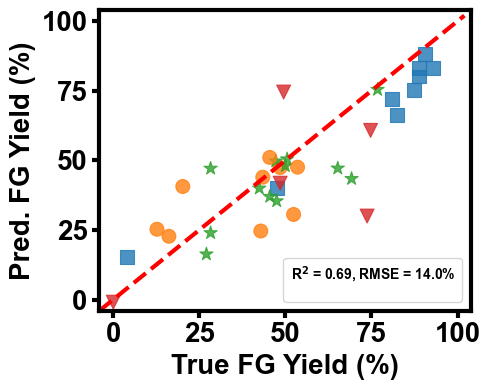

In [71]:
df_test['y_pred'] = pred_test
groups = df_test.groupby(['Material'])
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['v', 's', 'o', '*']
colors=['blue', 'red', 'green', 'orange']
sns.scatterplot(data=df_test, x='y_true', y='y_pred', 
                hue_order= ['CB', 'MC', 'TCB', 'PA'], markers=markers, hue='Material', edgecolor=None,
                style='Material', alpha=0.8, s=100)

#plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_xlabel('True FG Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)

r2 = r2_score (df_test['y_true'], df_test['y_pred']) 
ax.plot(x2, y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

rmse = np.sqrt (mean_squared_error(df_test['y_pred'], df_test['y_true']))

ax.legend( [], title='R$^2$ = {}, RMSE = {}%'.format(round(r2, 2), round (rmse, 1)),  
           frameon=True, ncol=2, fontsize=13, loc='lower right')
plt.xlim (-4, 104)
plt.ylim (-4, 104)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))
# Save
print ('r2 value: ', r2_score (df_test['y_true'], df_test['y_pred']))
plt.tight_layout()
plt.savefig('XGBPerformance_notemp_Nocurrent.jpeg', dpi=500)